# Import the libraries used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.stattools import acf
import seaborn as sns
import missingno as msno

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout

# from statsmodels.graphics.tsaplots import plot_acf

# plt.style.use('dark_background')

In [2]:
# To comment if you're running on Colab
data_path = Path('Data/')
data_path

WindowsPath('Data')

In [3]:
# To comment if you're running locally
# !git clone https://github.com/FabioLddo/time_series_energy_community_forecasting.git
# data_path = Path('time_series_energy_community_forecasting/Data/')

# Import the data

In [4]:
# Import lic_meteo file
df_meteo = pd.read_pickle(Path(data_path, 'ec_meteo/lic_meteo'))
df_meteo.head()

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533
2020-01-01 00:45:00+00:00,965.320000,5.639200,-2.406067,0.0,49.093333,0.923733
2020-01-01 01:00:00+00:00,965.300000,6.030800,-2.363267,0.0,47.546667,0.916733


In [5]:
# Import lic_meters file
df_meters = pd.read_pickle(Path(data_path, 'ec_meters/lic_meters'))
df_meters.head()

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   
2020-12-31 23:45:00+00:00   98.0   0.0  291.0   0.0  449.0   0.0  624.0   0.0   
2021-01-01 00:00:00+00:00  131.0   0.0  533.0   0.0  507.0   0.0  547.0   0.0   

                                    4        ...      17           18        \
                                e_pos e_neg  ...   e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...   670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...   525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...   499.0   0.0  436.0   0.0   
2020-12-31 23:45:00+00:00  386.815026   0.0  ...   695.0   0.0  362.0   0.0   
2021-01-01 00:00:00+00:00  390.256124   0.0  ...  1109.0   0.0  504.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  
2020-12-31 23:45:00+00:00   659.0   0.0     1.0   0.0   9380.0   0.0  
2021-01-01 00:00:00+00:00  2384.0   0.0     0.0   0.0  11750.0   0.0  

[5 rows x 44 columns]

In [6]:
# Import lic_nwp file
df_nwp = pd.read_pickle(Path(data_path, 'ec_nwp/lic_nwp'))
df_nwp.head()

ghi_backwards                                        \
                                    0       1       10     100  101  102  103   
2020-01-01 00:00:00+00:00          0.00    0.00  273.43   0.00  0.0  0.0  0.0   
2020-01-01 12:00:00+00:00        354.10  314.48    0.00  33.83  0.0  0.0  0.0   
2020-01-02 00:00:00+00:00          0.00    0.00  265.03   0.00  0.0  0.0  0.0   
2020-01-02 12:00:00+00:00        345.37  307.64    0.00  34.66  0.0  0.0  0.0   
2020-01-03 00:00:00+00:00          0.00    0.00   60.56   0.00  0.0  0.0  0.0   

                                                  ... temperature              \
                             104     105     106  ...         90    91    92    
2020-01-01 00:00:00+00:00  26.58  127.41  234.86  ...        5.27  4.30  3.57   
2020-01-01 12:00:00+00:00   0.00    0.00    0.00  ...        0.44  1.49  2.98   
2020-01-02 00:00:00+00:00  25.69  124.16  229.88  ...        3.81  2.69  1.60   
2020-01-02 12:00:00+00:00   0.00    0.00    0.00  ...        0.83  1.70  2.81   
2020-01-03 00:00:00+00:00  25.68  121.78  221.89  ...        2.87  2.05  1.34   

                                                                     
                            93    94    95    96    97    98    99   
2020-01-01 00:00:00+00:00  3.00  2.57  2.21  1.88  1.59  1.32  1.08  
2020-01-01 12:00:00+00:00  4.72  6.54  8.30  9.51  9.81  9.15  7.88  
2020-01-02 00:00:00+00:00  0.62 -0.21 -0.31 -0.11  0.37  0.50  0.67  
2020-01-02 12:00:00+00:00  4.09  5.42  6.75  7.58  7.72  7.12  6.15  
2020-01-03 00:00:00+00:00  0.72  0.24 -0.08 -0.26 -0.26 -0.15  0.06  

[5 rows x 507 columns]

Check columns of the 3 datasets

In [7]:
# Check df_meteo columns
df_meteo.columns

Index(['AirPressure', 'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot',
       'RelHumidity', 'WindSpeed'],
      dtype='object')

In [8]:
# Check df_meters columns
df_meters.columns

MultiIndex([(        0, 'e_pos'),
            (        0, 'e_neg'),
            (        1, 'e_pos'),
            (        1, 'e_neg'),
            (        2, 'e_pos'),
            (        2, 'e_neg'),
            (        3, 'e_pos'),
            (        3, 'e_neg'),
            (        4, 'e_pos'),
            (        4, 'e_neg'),
            (        5, 'e_pos'),
            (        5, 'e_neg'),
            (        6, 'e_pos'),
            (        6, 'e_neg'),
            (        7, 'e_pos'),
            (        7, 'e_neg'),
            (        8, 'e_pos'),
            (        8, 'e_neg'),
            (        9, 'e_pos'),
            (        9, 'e_neg'),
            (       10, 'e_pos'),
            (       10, 'e_neg'),
            (       11, 'e_pos'),
            (       11, 'e_neg'),
            (       12, 'e_pos'),
            (       12, 'e_neg'),
            (       13, 'e_pos'),
            (       13, 'e_neg'),
            (       14, 'e_pos'),
            ( 

In [9]:
# Check df_nwp columns
df_nwp.columns

MultiIndex([('ghi_backwards',   0),
            ('ghi_backwards',   1),
            ('ghi_backwards',  10),
            ('ghi_backwards', 100),
            ('ghi_backwards', 101),
            ('ghi_backwards', 102),
            ('ghi_backwards', 103),
            ('ghi_backwards', 104),
            ('ghi_backwards', 105),
            ('ghi_backwards', 106),
            ...
            (  'temperature',  90),
            (  'temperature',  91),
            (  'temperature',  92),
            (  'temperature',  93),
            (  'temperature',  94),
            (  'temperature',  95),
            (  'temperature',  96),
            (  'temperature',  97),
            (  'temperature',  98),
            (  'temperature',  99)],
           length=507)

# Exploratory Data Analysis

Visualize the data in df_meteo

<Axes: >

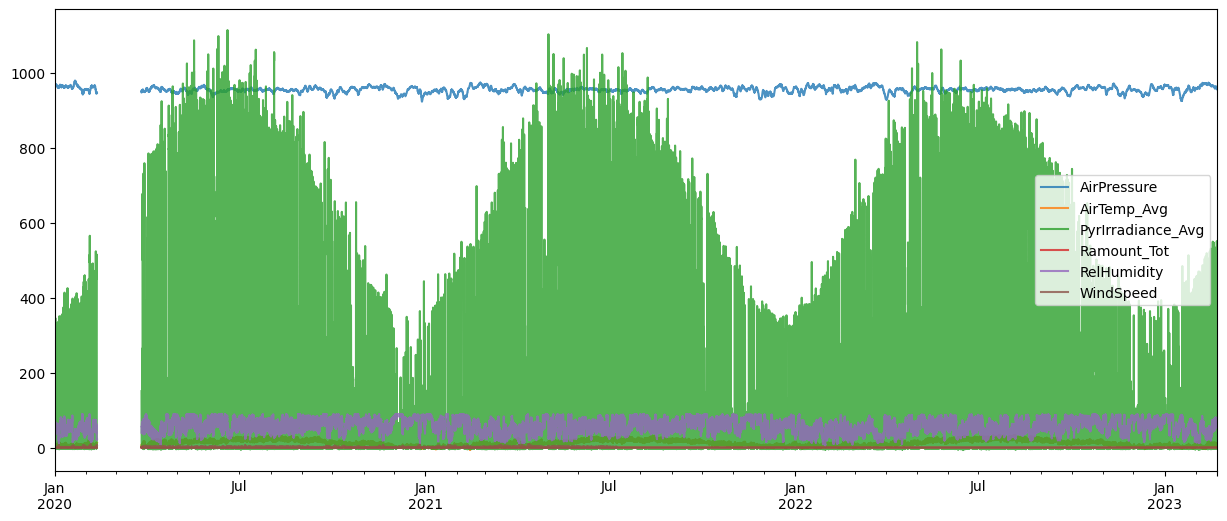

In [10]:
df_meteo.plot(figsize=(15, 6), alpha=0.8)

Visualize the data in df_meters

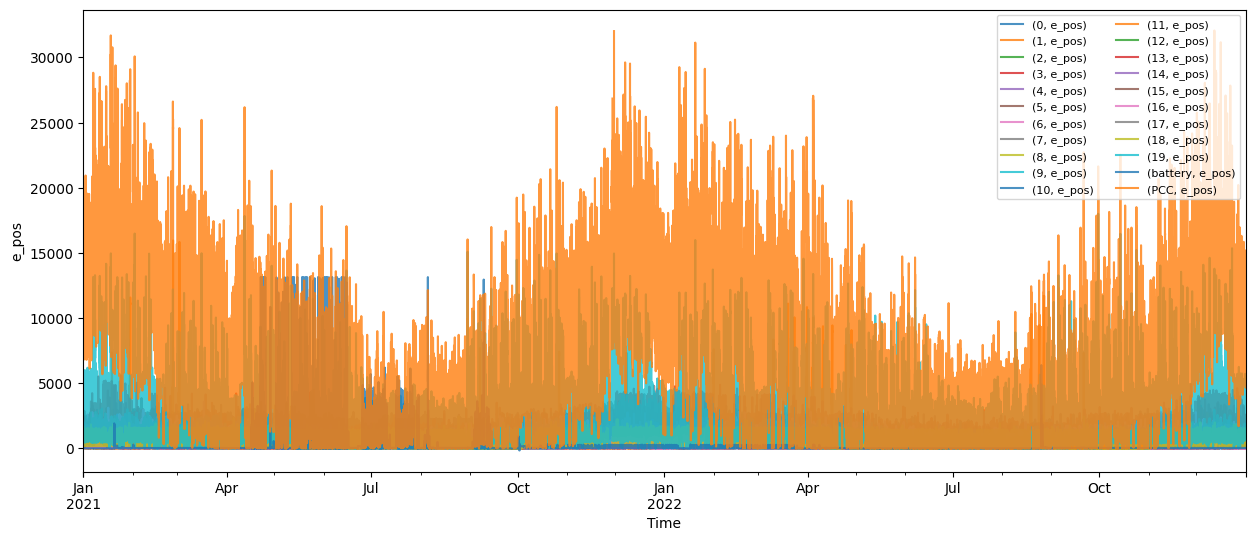

In [11]:
# Plot the e_pos measure in the df_meters dataset
e_pos_cols = [col for col in df_meters.columns if 'e_pos' in col]

# Plot the e_pos columns against the DataFrame's index
df_meters[e_pos_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

df_meters_old = df_meters.copy()  # Save for later

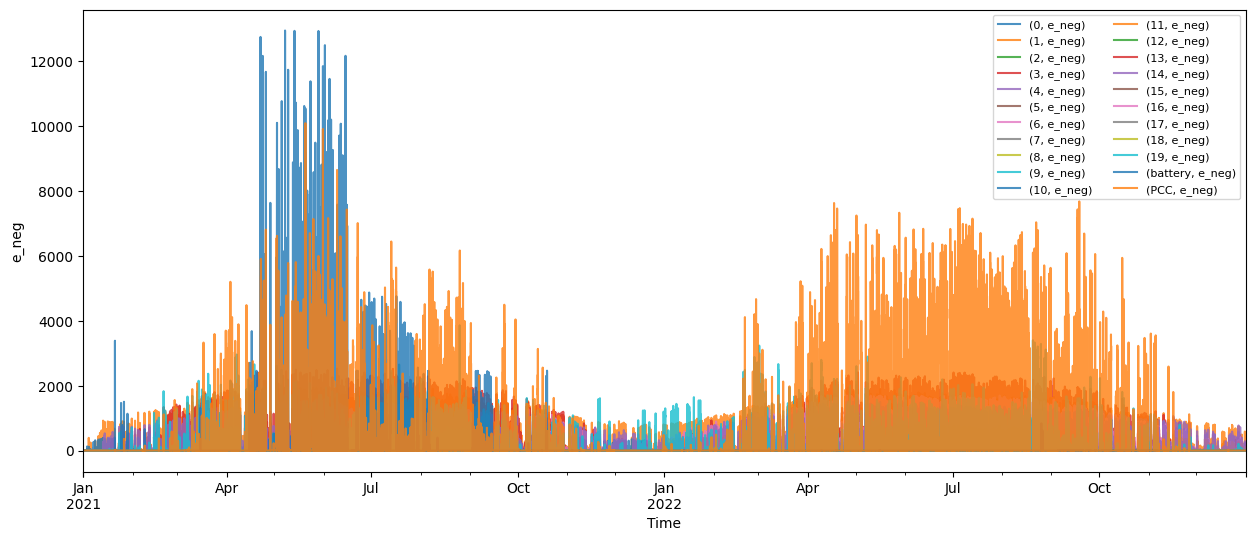

In [12]:
# Plot the e_neg measure in the df_meters dataset
e_neg_cols = [col for col in df_meters.columns if 'e_neg' in col]

# Plot the e_neg columns against the DataFrame's index
df_meters[e_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

Visualize the data in df_nwp

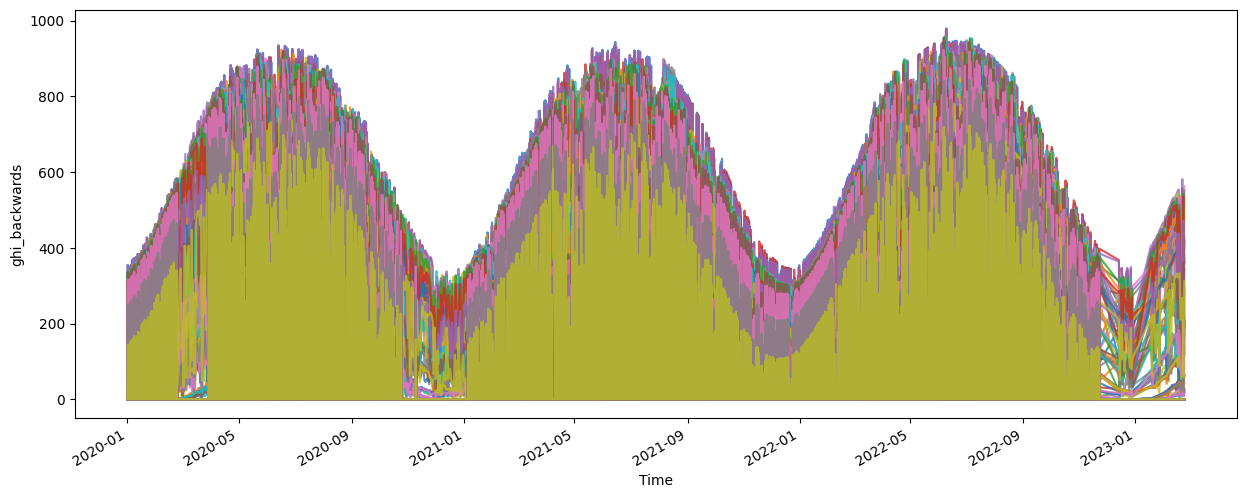

In [13]:
# Plot the ghi_backwards measure in the df_nwp dataset
e_ghi_cols = [col for col in df_nwp.columns if 'ghi_backwards' in col]

# Plot the ghi_backwards columns against the DataFrame's index
df_nwp[e_ghi_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('ghi_backwards')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

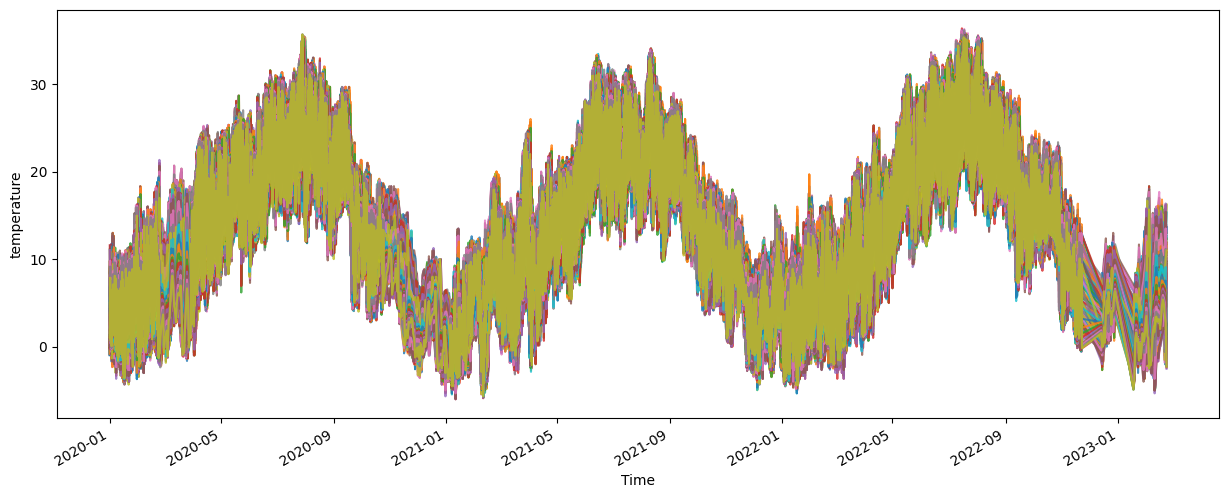

In [14]:
# Plot the temperature measure in the df_nwp dataset
e_temp_cols = [col for col in df_nwp.columns if 'temperature' in col]

# Plot the temperature columns against the DataFrame's index
df_nwp[e_temp_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('temperature')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

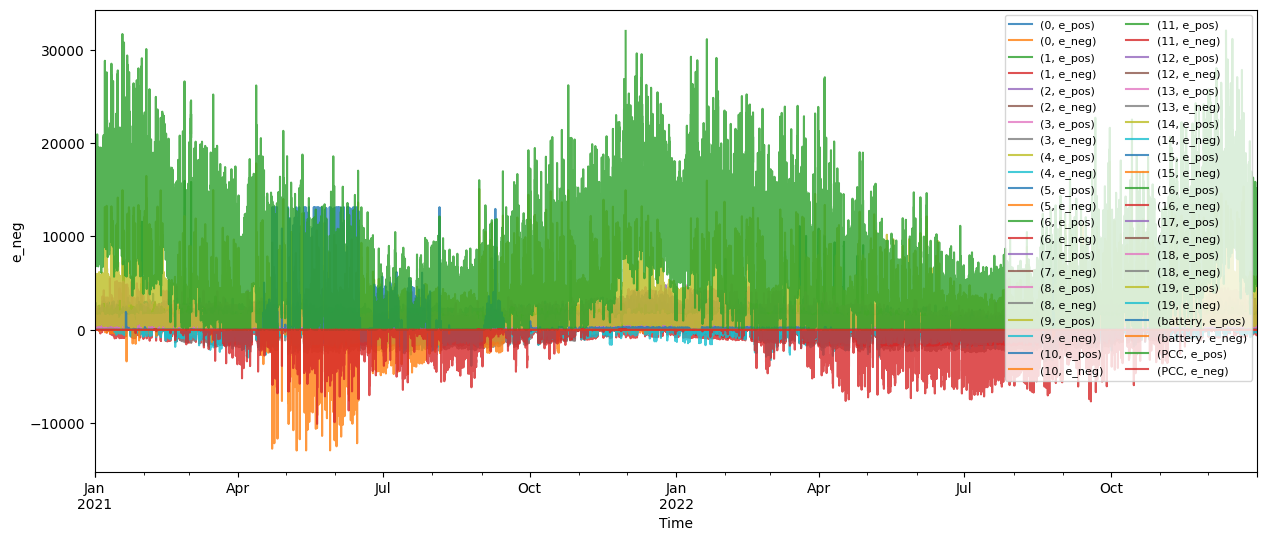

In [15]:
df = df_meters.copy()
df[e_neg_cols] = -df[e_neg_cols]

df.plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [16]:
# TODO:
# - Check stationarity
# - Check seasonality
# - Check autocorrelation
# Do some box plots of the features (maybe)

# Clean the data

Comments on the data after having explored it:
- It is requested to resample the data at hourly rate
- It is requested to sum-up the battery data to the PCC data as the energy stored in the battery, as there is a discrepancy with the meters data.

In [17]:
# Check for missing values
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 1269 
---------

df_meteo:
 26022 
---------

df_nwp:
 0 
---------



In [18]:
# Check the shapes of the datasets
print('df_meters:\n', df_meters.shape, '\n---------\n')

print('df_meteo:\n', df_meteo.shape, '\n---------\n')

print('df_nwp:\n', df_nwp.shape, '\n---------\n')

df_meters:
 (70080, 44) 
---------

df_meteo:
 (110208, 6) 
---------

df_nwp:
 (2024, 507) 
---------



## Visualize the position of the missing values

<Axes: >

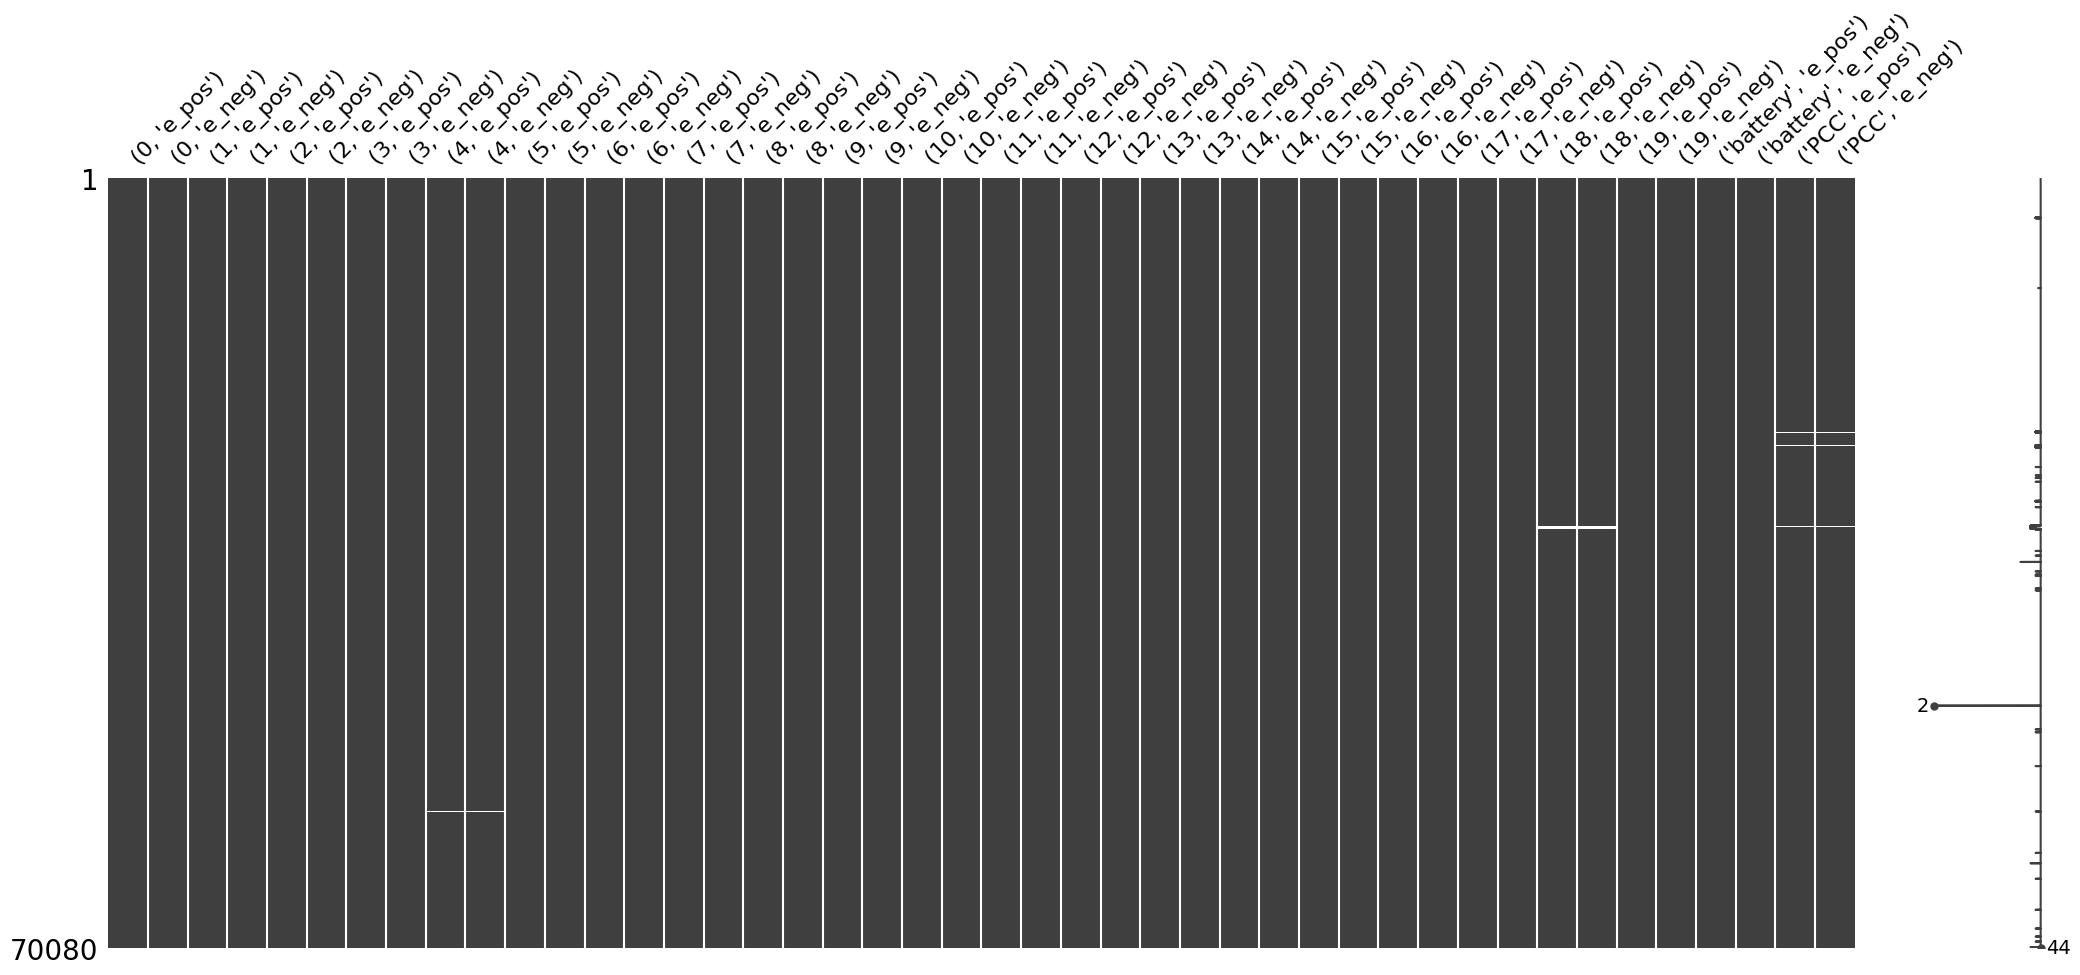

In [19]:
# Visualize the position of null values in the time series of df_meters
msno.matrix(df_meters)

<Axes: >

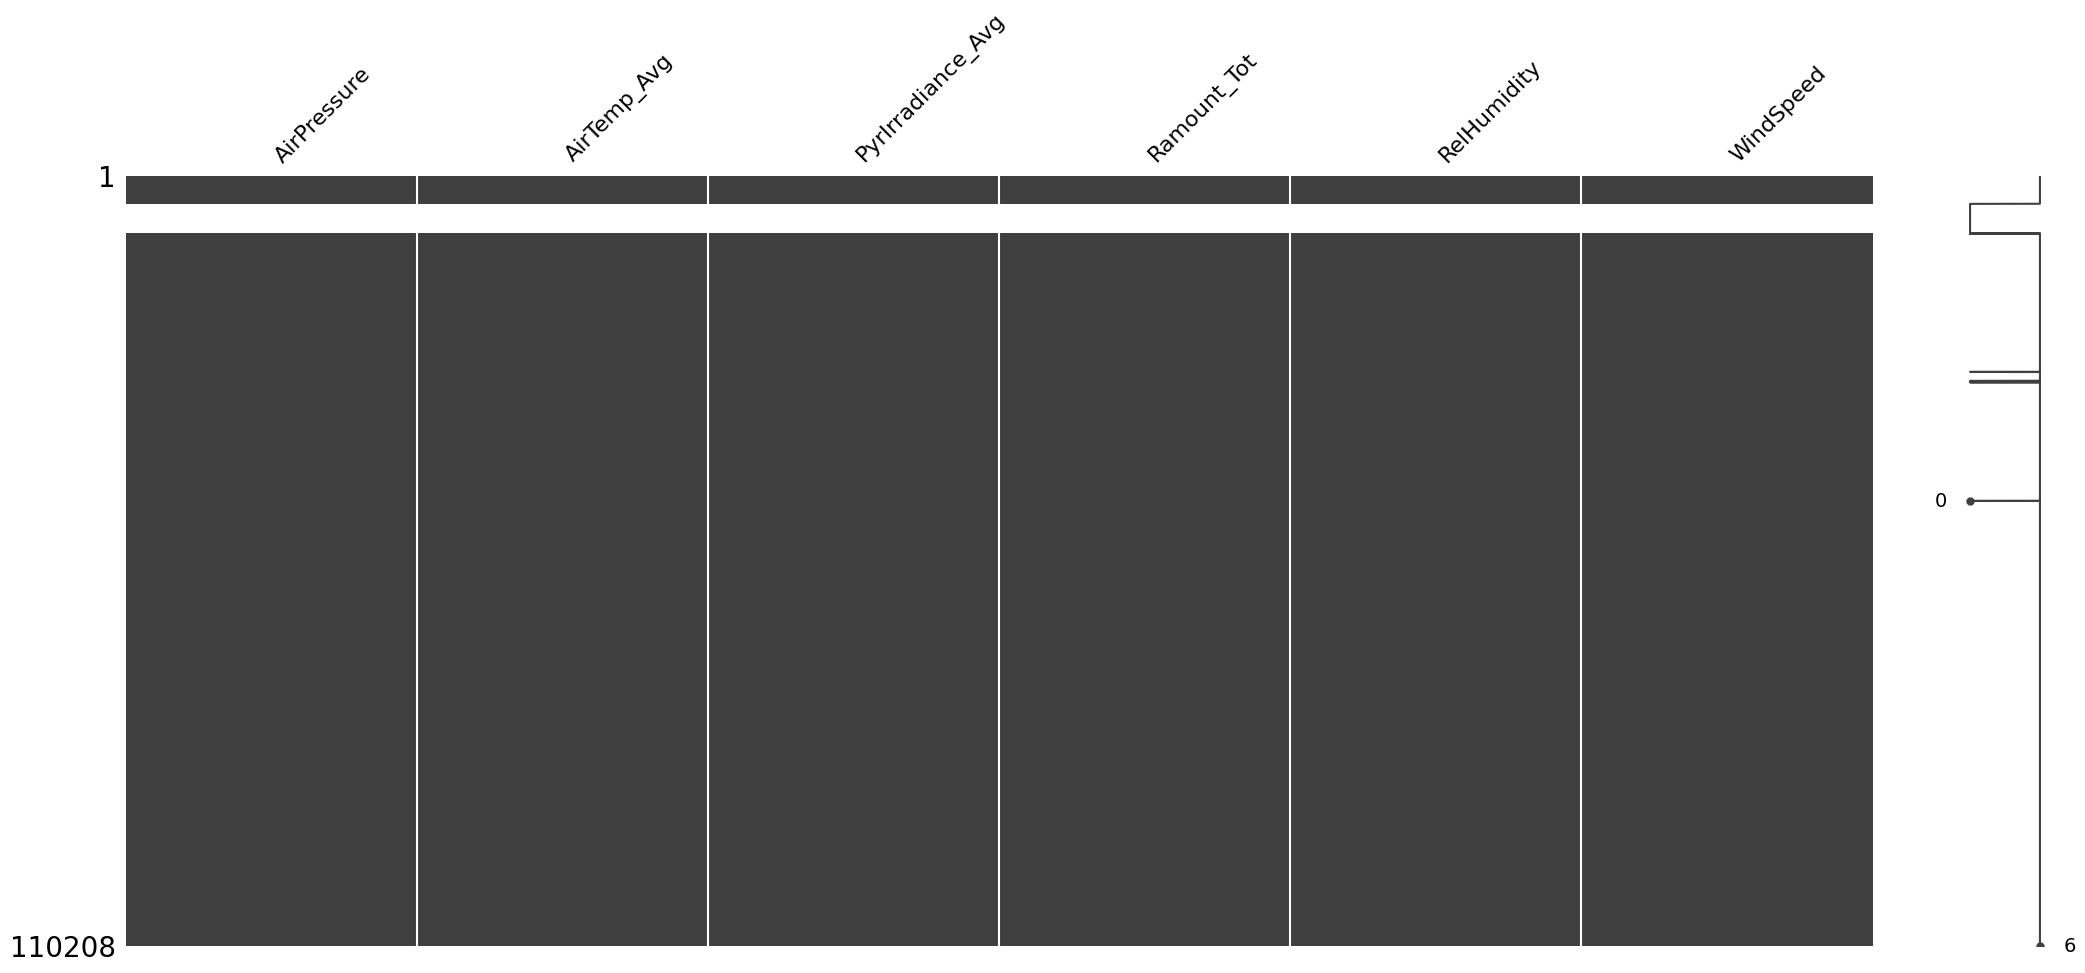

In [20]:
# Visualize the position of null values in the time series of df_meteo
msno.matrix(df_meteo)

<Axes: >

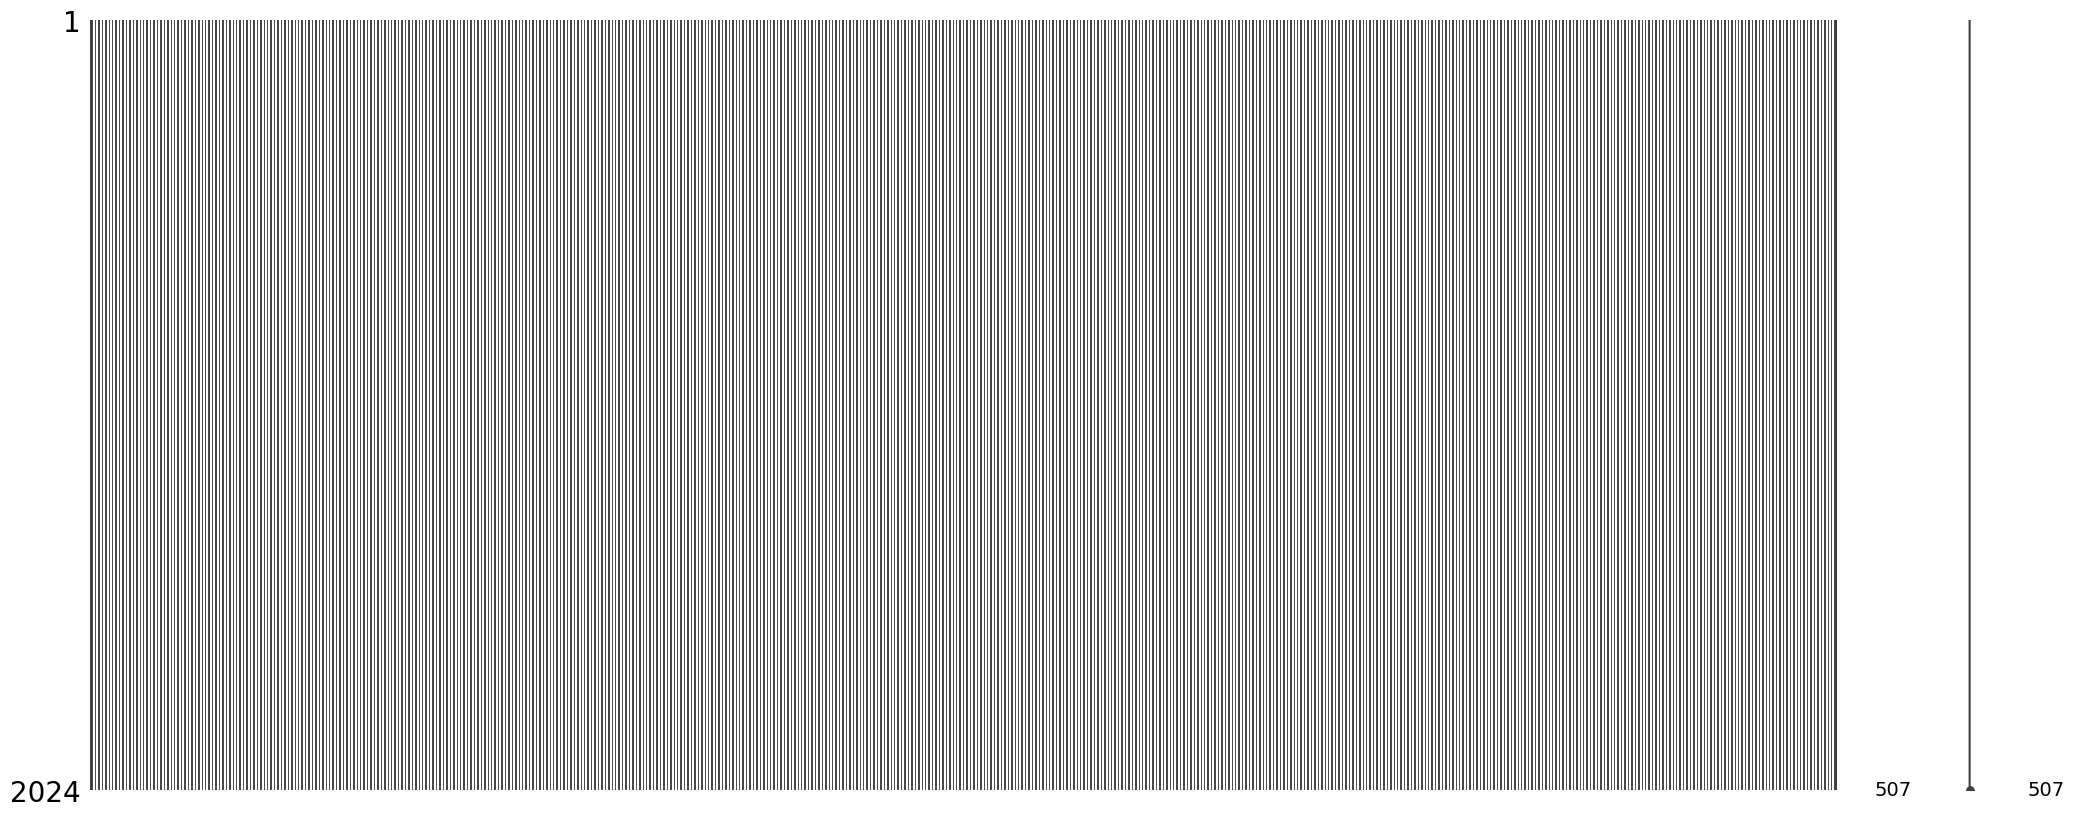

In [21]:
# Visualize the position of null values in the time series of df_nwp
msno.matrix(df_nwp)

## Resample the data at hourly rate

In [22]:
# Check data sampled at 15 minutes intervals in df_meteo
df_meteo.head(3)

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533


In [23]:
# Check data sampled at 15 minutes intervals in df_meters
df_meters.head(3)

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   

                                    4        ...     17           18        \
                                e_pos e_neg  ...  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...  670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...  525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...  499.0   0.0  436.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  

[3 rows x 44 columns]

In [24]:
# Resample the data at hourly rate
df_meteo = df_meteo.resample('H').mean()  # Get average meteo values at hourly rate
df_meters = df_meters.resample('H').sum()  # Sum the measurements of meters to get hourly values
# df_nwp = df_nwp.resample('H').interpolate(method='linear')  # Interpolate prediction values to get hourly values

In [25]:
# Check data sampled at 1 hour intervals in df_meeto
df_meteo.head(3)

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.396667,5.586717,-2.524517,0.0,48.945000,0.908617
2020-01-01 01:00:00+00:00,965.388333,5.911933,-2.392700,0.0,47.821667,0.877183
2020-01-01 02:00:00+00:00,965.216667,6.480783,-2.452333,0.0,45.773333,1.068467


In [26]:
# Check data sampled at 1 hour intervals in df_meters
df_meters.head(3)

0             1             2             3  \
                           e_pos e_neg   e_pos e_neg   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00  447.0   0.0  1686.0   0.0  1721.0   0.0  2509.0   
2021-01-01 00:00:00+00:00  485.0   0.0   810.0   0.0  1862.0   0.0  2469.0   
2021-01-01 01:00:00+00:00  218.0   0.0  1433.0   0.0  1679.0   0.0  2330.0   

                                           4        ...      17            18  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00   0.0  1628.982403   0.0  ...  2389.0   0.0  2119.0   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  3317.0   0.0  1984.0   
2021-01-01 01:00:00+00:00   0.0  1317.436378   0.0  ...  3390.0   0.0  1639.0   

                                     19       battery            PCC        
                          e_neg   e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00   0.0  6427.0   0.0     3.0   0.0  40947.0   0.0  
2021-01-01 00:00:00+00:00   0.0  6266.0   0.0     2.0   0.0  37873.0   0.0  
2021-01-01 01:00:00+00:00   0.0  7146.0   0.0     3.0   0.0  40145.0   0.0  

[3 rows x 44 columns]

In [27]:
# We slice the data from '2020-12-31 23:00:00+00:00' to '2022-11-28 22:00:00+00:00' so that we have full data fro all the datasets
start_date = '2021-01-01 00:00:00+00:00'

end_date = '2022-11-28 22:00:00+00:00'

df_meteo = df_meteo.loc[start_date:end_date]
df_meters= df_meters.loc[start_date:end_date]
df_nwp = df_nwp.loc[start_date:end_date]

# sort the columns in the multiindex
sorted_nwp = df_nwp.sort_index(axis=1, level=[0, 1])

In [28]:
sorted_nwp.head(3)

ghi_backwards                                     \
                                    0    1    2    3    4    5    6    7     
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-02 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-03 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                         ... temperature                    \
                             8      9    ...         159   160   161   162   
2021-01-01 00:00:00+00:00  13.60  45.82  ...        3.91  2.65  1.47  0.46   
2021-01-02 00:00:00+00:00  12.95  54.19  ...        2.79  1.40  0.20 -0.97   
2021-01-03 00:00:00+00:00   6.86   5.70  ...        3.67  2.91  2.34  1.89   

                                                               
                            163   164   165   166   167   168  
2021-01-01 00:00:00+00:00 -0.31 -0.74 -0.97 -1.27 -1.62 -1.85  
2021-01-02 00:00:00+00:00 -1.91 -2.71 -3.38 -4.05 -3.93 -3.54  
2021-01-03 00:00:00+00:00  1.57  1.34  1.09  0.76  0.35 -0.24  

[3 rows x 507 columns]

In [29]:
# To have hourly samples in df_nwp we use its predictions for the next hours 

def create_empty_hourly_df(start_date, end_date):
    hourly_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='H'),
                                columns=range(24))
    return hourly_df

def get_hourly(df_preds, df_hourly):
    for i in range(len(df_hourly)):
        time = df_hourly.index[i]
        preds_row = df_preds.loc[df_preds.index <= time].iloc[-1]
        delta = time - preds_row.name  
        hours_diff = delta.total_seconds() / 3600
        df_hourly.iloc[i] = df_preds.loc[df_preds.index <= time].iloc[-1, int(hours_diff):24 + int(hours_diff)].values
    return df_hourly

dfs_list = []
for column in ['ghi_backwards', 'temperature', 'relativehumidity']:
    df = sorted_nwp[column]
    hourly_df = create_empty_hourly_df(start_date, end_date)
    hourly_df = get_hourly(df, hourly_df)
    dfs_list.append(hourly_df)

# concatenate the 3 hourly dfs adding the name of the column as level 1 index of the multiindex
hourly_nwp_df = pd.concat(dfs_list, axis=1, keys=['ghi_backwards', 'temperature', 'relativehumidity'])


In [30]:
df_nwp = hourly_nwp_df
df_nwp

ghi_backwards                                     \
                                     0    1    2    3     4      5      6    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2021-01-01 01:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2021-01-01 02:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0   13.6   
2021-01-01 03:00:00+00:00           0.0  0.0  0.0  0.0   0.0   13.6  45.82   
2021-01-01 04:00:00+00:00           0.0  0.0  0.0  0.0  13.6  45.82  72.37   
...                                 ...  ...  ...  ...   ...    ...    ...   
2022-11-28 18:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 19:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 20:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 21:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 22:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   

                                                ... relativehumidity         \
                              7      8      9   ...               14     15   
2021-01-01 00:00:00+00:00    0.0   13.6  45.82  ...             87.0   92.0   
2021-01-01 01:00:00+00:00   13.6  45.82  72.37  ...             92.0   98.0   
2021-01-01 02:00:00+00:00  45.82  72.37  59.97  ...             98.0  100.0   
2021-01-01 03:00:00+00:00  72.37  59.97  61.64  ...            100.0   99.0   
2021-01-01 04:00:00+00:00  59.97  61.64  75.82  ...             99.0  100.0   
...                          ...    ...    ...  ...              ...    ...   
2022-11-28 18:00:00+00:00    0.0    0.0    0.0  ...             89.0   79.0   
2022-11-28 19:00:00+00:00    0.0    0.0    0.0  ...             79.0   71.0   
2022-11-28 20:00:00+00:00    0.0    0.0    0.0  ...             71.0   65.0   
2022-11-28 21:00:00+00:00    0.0    0.0    0.0  ...             65.0   61.0   
2022-11-28 22:00:00+00:00    0.0    0.0   1.85  ...             61.0   60.0   

                                                                            \
                              16     17     18     19     20     21     22   
2021-01-01 00:00:00+00:00   98.0  100.0   99.0  100.0  100.0  100.0   99.0   
2021-01-01 01:00:00+00:00  100.0   99.0  100.0  100.0  100.0   99.0  100.0   
2021-01-01 02:00:00+00:00   99.0  100.0  100.0  100.0   99.0  100.0  100.0   
2021-01-01 03:00:00+00:00  100.0  100.0  100.0   99.0  100.0  100.0  100.0   
2021-01-01 04:00:00+00:00  100.0  100.0   99.0  100.0  100.0  100.0  100.0   
...                          ...    ...    ...    ...    ...    ...    ...   
2022-11-28 18:00:00+00:00   71.0   65.0   61.0   60.0   64.0   72.0   80.0   
2022-11-28 19:00:00+00:00   65.0   61.0   60.0   64.0   72.0   80.0   85.0   
2022-11-28 20:00:00+00:00   61.0   60.0   64.0   72.0   80.0   85.0   86.0   
2022-11-28 21:00:00+00:00   60.0   64.0   72.0   80.0   85.0   86.0   87.0   
2022-11-28 22:00:00+00:00   64.0   72.0   80.0   85.0   86.0   87.0   87.0   

                                  
                              23  
2021-01-01 00:00:00+00:00  100.0  
2021-01-01 01:00:00+00:00  100.0  
2021-01-01 02:00:00+00:00  100.0  
2021-01-01 03:00:00+00:00  100.0  
2021-01-01 04:00:00+00:00  100.0  
...                          ...  
2022-11-28 18:00:00+00:00   85.0  
2022-11-28 19:00:00+00:00   86.0  
2022-11-28 20:00:00+00:00   87.0  
2022-11-28 21:00:00+00:00   87.0  
2022-11-28 22:00:00+00:00   86.0  

[16727 rows x 72 columns]

## Sum up the battery data to the PCC data

We had to do it because it happens that sometimes the battery starts storing and providing energy to the stations

In [31]:
# Check PCC data
df_meters['PCC'].head(3)

,e_pos,e_neg
2021-01-01 00:00:00+00:00,37873.0,0.0
2021-01-01 01:00:00+00:00,40145.0,0.0
2021-01-01 02:00:00+00:00,35965.0,0.0


In [32]:
# Check battery data
df_meters['battery'].head(3)

,e_pos,e_neg
2021-01-01 00:00:00+00:00,2.0,0.0
2021-01-01 01:00:00+00:00,3.0,0.0
2021-01-01 02:00:00+00:00,2.0,0.0


In [33]:
# Duplicate the column PCC to then sum it up with the battery data
new_columns = pd.DataFrame(df_meters['PCC'].values, index=df_meters['PCC'].index, 
                           columns=[('PCC_batt', 'e_pos'), ('PCC_batt', 'e_neg')])
df_meters = pd.concat([df_meters, new_columns], axis=1)

In [34]:
# Check if the new 'PCC_batt' column was added
df_meters.columns[-5]

('battery', 'e_neg')

In [35]:
# Fortunately the data is aligned, so we can simply sum the features
# Sum up battery and PCC data
df_meters[('PCC_batt', 'e_pos')] += df_meters[('battery', 'e_pos')]
df_meters[('PCC_batt', 'e_neg')] += df_meters[('battery', 'e_neg')]

In [36]:
 # Check that the sum was successful
df_meters[['PCC', 'battery', 'PCC_batt']].head(3)

# We'll keep the old columns 'PCC' and 'battery' in case we'll need them later

PCC       battery       PCC_batt      
                             e_pos e_neg   e_pos e_neg    e_pos e_neg
2021-01-01 00:00:00+00:00  37873.0   0.0     2.0   0.0  37875.0   0.0
2021-01-01 01:00:00+00:00  40145.0   0.0     3.0   0.0  40148.0   0.0
2021-01-01 02:00:00+00:00  35965.0   0.0     2.0   0.0  35967.0   0.0

## Impute the missing values on df_meters

In [37]:
# Check for nulls in the datasets
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 0 
---------

df_meteo:
 0 
---------

df_nwp:
 0 
---------



<Axes: >

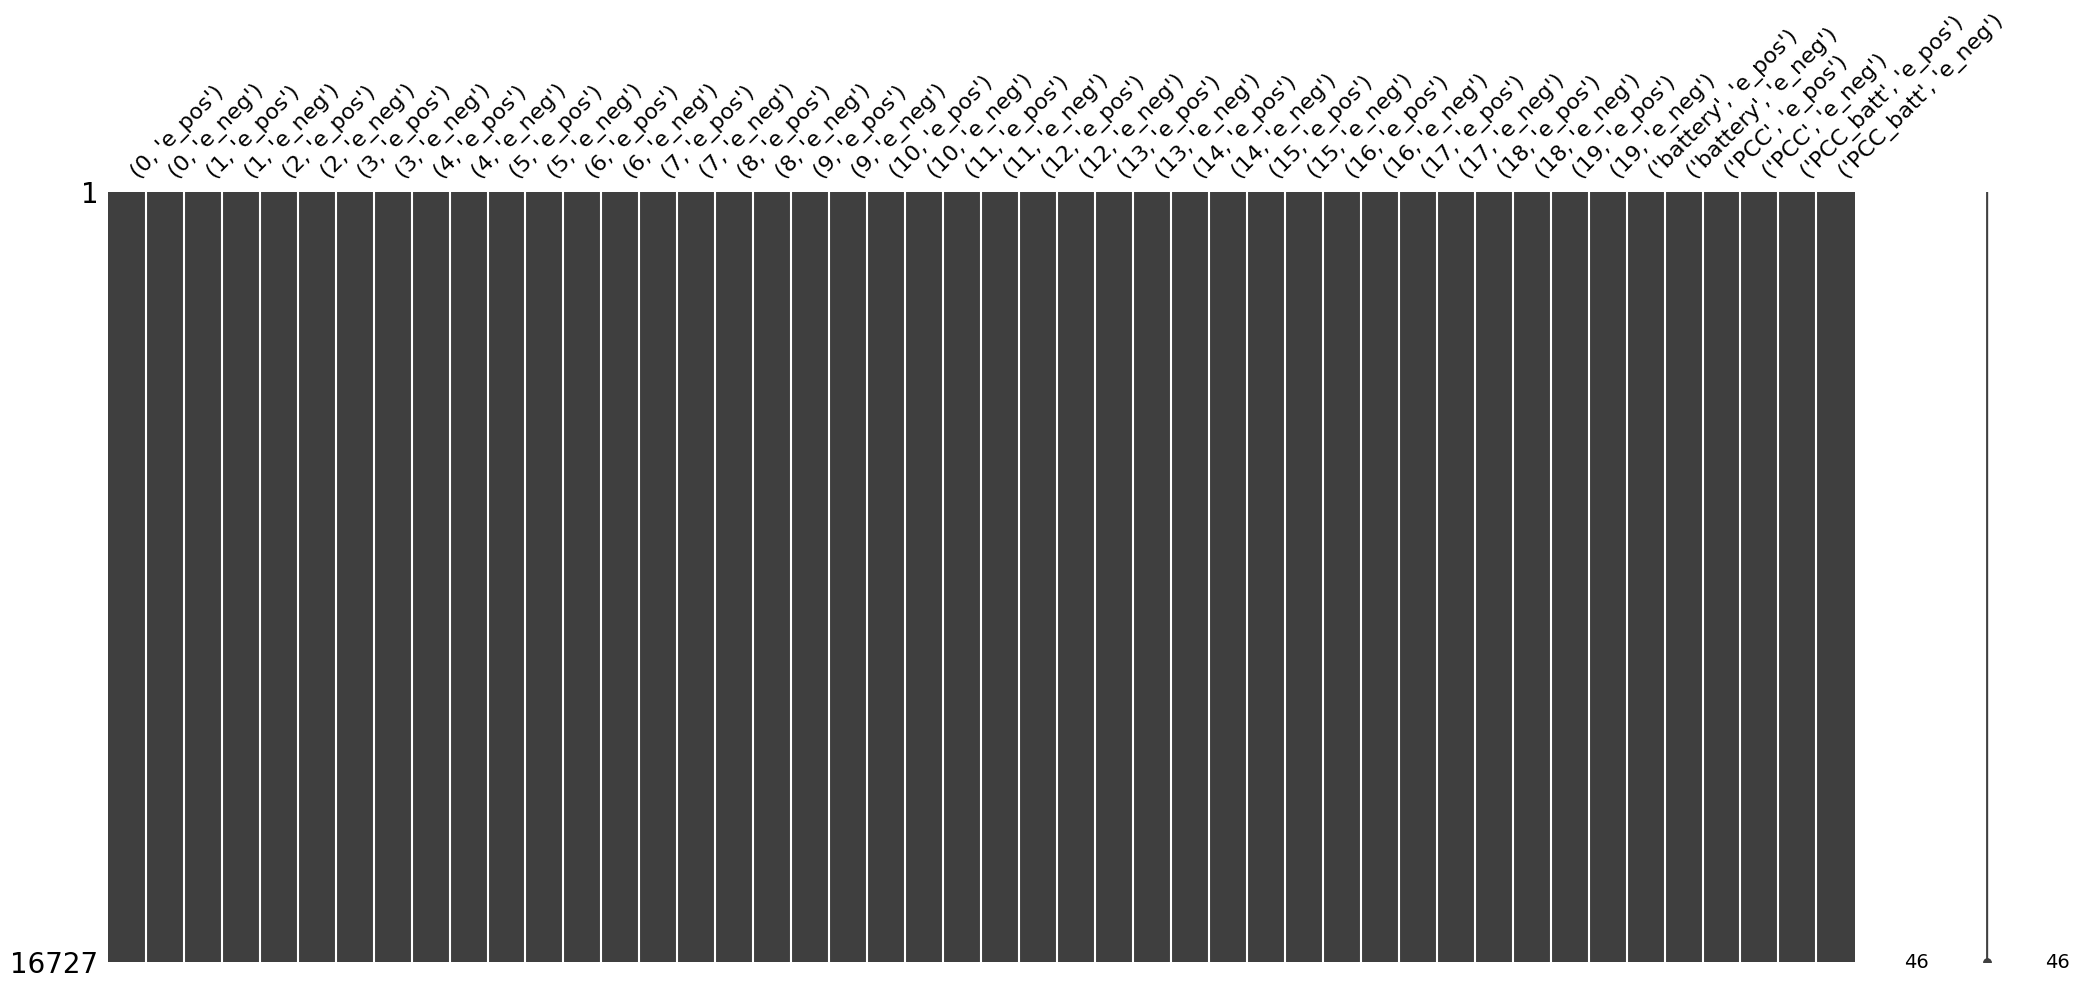

In [38]:
# Visualize the position of the missing values 
msno.matrix(df_meters)

In [39]:
# Impute missing values with the mean
print('Nulls before numerical features imputation:', df_meters.isna().sum().sum())

df_meters = df_meters.fillna(df_meters.mean())

print('Nulls after numerical features imputation:', df_meters.isna().sum().sum())

Nulls before numerical features imputation: 0
Nulls after numerical features imputation: 0


## Remove the multi index

It is not very intuitive to work with a multi-index dataframe, so we'll convert it to a single index dataframe

In [40]:
# Check initial state of df_meters
df_meters.head(1)

0            1             2             3  \
                           e_pos e_neg  e_pos e_neg   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00  485.0   0.0  810.0   0.0  1862.0   0.0  2469.0   

                                           4        ...      18            19  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  1984.0   0.0  6266.0   

                                battery            PCC       PCC_batt        
                          e_neg   e_pos e_neg    e_pos e_neg    e_pos e_neg  
2021-01-01 00:00:00+00:00   0.0     2.0   0.0  37873.0   0.0  37875.0   0.0  

[1 rows x 46 columns]

In [41]:
# Check initial state of df_nwp
df_nwp.head(1)

ghi_backwards                                     \
                                     0    1    2    3    4    5    6    7    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                        ... relativehumidity              \
                             8      9   ...               14    15    16   
2021-01-01 00:00:00+00:00  13.6  45.82  ...             87.0  92.0  98.0   

                                                                          
                              17    18     19     20     21    22     23  
2021-01-01 00:00:00+00:00  100.0  99.0  100.0  100.0  100.0  99.0  100.0  

[1 rows x 72 columns]

In [42]:
# Remove the multi index from df_meters and df_nwp
# df_meteo already has no multi index
df_meters_multi = df_meters
df_meters.columns = [f'{col[1]}_{col[0]}' for col in df_meters.columns]
df_nwp.columns = [f'{col[1]}_{col[0]}' for col in df_nwp.columns]

In [43]:
# Check result on df_meters
df_meters.head(1)

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,e_pos_18,e_neg_18,e_pos_19,e_neg_19,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt
2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,0.0,...,1984.0,0.0,6266.0,0.0,2.0,0.0,37873.0,0.0,37875.0,0.0


In [44]:
# Check result on df_nwp
df_nwp.head(1)

,0_ghi_backwards,1_ghi_backwards,2_ghi_backwards,3_ghi_backwards,4_ghi_backwards,5_ghi_backwards,6_ghi_backwards,7_ghi_backwards,8_ghi_backwards,9_ghi_backwards,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
2021-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.6,45.82,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0


## Merge the datasets to get a single dataset with all the features
Some data has different time windows, so there will be some NaN values.
We decided to drop the windows where we don't have data from all the features.

In [45]:
# Check the range of dates in the three datasets
print('Start date:\n',
      'df_meters:', df_meters.index.min(), '\n',
      'df_meteo:', df_meteo.index.min(), '\n',
      'df_nwp:', df_nwp.index.min(), '\n')
      
print('End date:\n',
      'df_meters:', df_meters.index.max(), '\n',
      'df_meteo:', df_meteo.index.max(), '\n',
      'df_nwp:', df_nwp.index.max())

Start date:
 df_meters: 2021-01-01 00:00:00+00:00 
 df_meteo: 2021-01-01 00:00:00+00:00 
 df_nwp: 2021-01-01 00:00:00+00:00 

End date:
 df_meters: 2022-11-28 22:00:00+00:00 
 df_meteo: 2022-11-28 22:00:00+00:00 
 df_nwp: 2022-11-28 22:00:00+00:00


In [46]:
df = pd.concat([df_meters, df_meteo, df_nwp], axis=1)

In [47]:
df.shape

(16727, 124)

In [48]:
df.head(3)

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,0.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


## Sum up the data about station 10 and 11

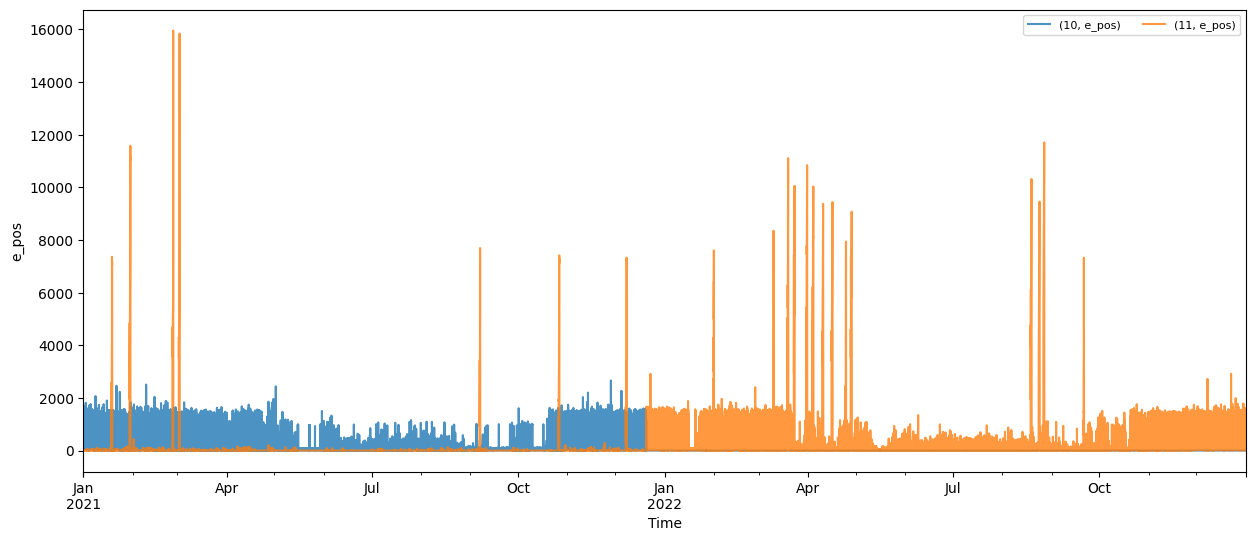

In [49]:
# The data in station 10 and 11 seem to be from the same source/people who changed station, so we'll sum them up
df_meters_old[e_pos_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

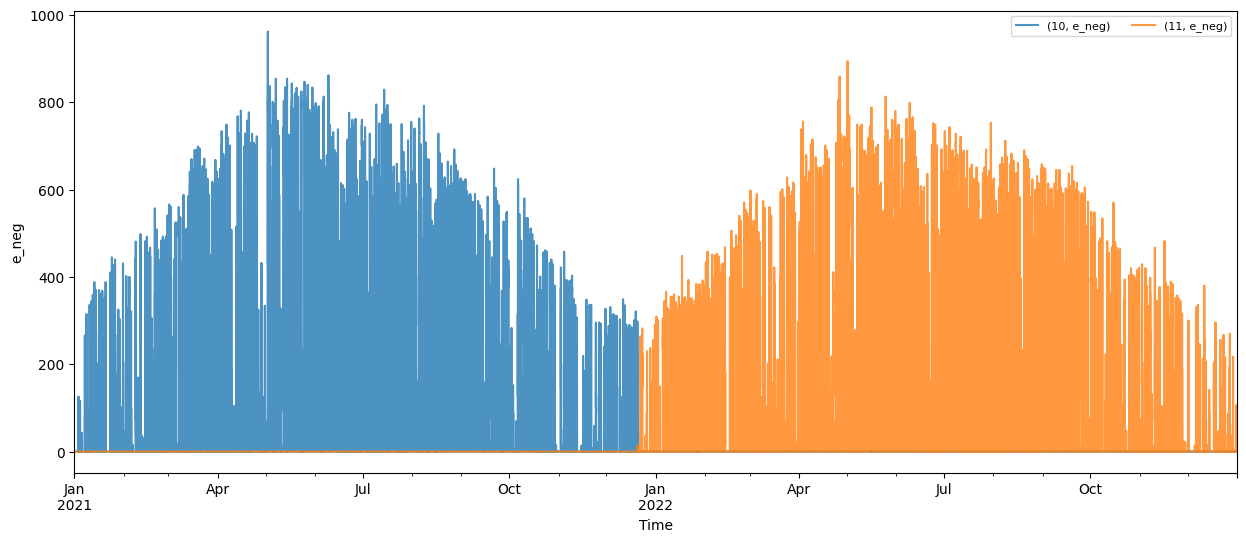

In [50]:
df_meters_old[e_neg_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [51]:
# Identify the date in which the two stations were swapped
trial_pos = df_meters_old[e_pos_cols[10:12]]
trial_neg = df_meters_old[e_neg_cols[10:12]]

In [52]:
trial_pos = trial_pos.reset_index()
trial_neg = trial_neg.reset_index()

In [53]:
# Get the number of samples in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')].shape

(2976, 3)

In [54]:
# Inspect e_pos values in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')][1870:1885]

,index,10,11
,,e_pos,e_pos
33938,2021-12-20 11:30:00+00:00,0.0,0.0
33939,2021-12-20 11:45:00+00:00,0.0,0.0
33940,2021-12-20 12:00:00+00:00,0.0,0.0
33941,2021-12-20 12:15:00+00:00,0.0,0.0
33942,2021-12-20 12:30:00+00:00,6.0,0.0
33943,2021-12-20 12:45:00+00:00,0.0,0.0
33944,2021-12-20 13:00:00+00:00,0.0,NaN
33945,2021-12-20 13:15:00+00:00,0.0,NaN
33946,2021-12-20 13:30:00+00:00,0.0,NaN


In [55]:
# Inspect e_neg values in december 2021
trial_neg[(trial_neg['index'] >= '2021-12-01') & (trial_neg['index'] < '2022-01-01')][1870:1885]

,index,10,11
,,e_neg,e_neg
33938,2021-12-20 11:30:00+00:00,290.0,0.0
33939,2021-12-20 11:45:00+00:00,298.0,0.0
33940,2021-12-20 12:00:00+00:00,288.0,0.0
33941,2021-12-20 12:15:00+00:00,275.0,0.0
33942,2021-12-20 12:30:00+00:00,238.0,0.0
33943,2021-12-20 12:45:00+00:00,211.0,0.0
33944,2021-12-20 13:00:00+00:00,0.0,NaN
33945,2021-12-20 13:15:00+00:00,0.0,NaN
33946,2021-12-20 13:30:00+00:00,0.0,NaN


In [56]:
# The switch happens in the days around '2021-12-20 13:00:00+00:00'

# Add Date column to the dataframe
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df['e_neg_10'] = df['e_neg_11']
df['e_pos_10'] = df['e_pos_11']
df =df.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df = df.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df.head(3)

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


In [57]:
# Do the same on just df_meters because we need it to perform other tasks
# Add Date column to the dataframe
df_meters.reset_index(inplace=True)
df_meters.rename(columns={'index': 'Date'}, inplace=True)

df_meters['Date'] = pd.to_datetime(df_meters['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df_meters['e_neg_10'] = df_meters['e_neg_11']
df_meters['e_pos_10'] = df_meters['e_pos_11']
df_meters = df_meters.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df_meters = df_meters.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df_meters.head(3)

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,e_pos_17,e_neg_17,e_pos_18,e_neg_18,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt
0,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,1984.0,0.0,6266.0,0.0,2.0,0.0,37873.0,0.0,37875.0,0.0
1,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,1639.0,0.0,7146.0,0.0,3.0,0.0,40145.0,0.0,40148.0,0.0
2,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,1421.0,0.0,7299.0,0.0,2.0,0.0,35965.0,0.0,35967.0,0.0


## Get columns e_pos and e_neg containing the concatenatenated values of all the stations

In [58]:
df_new = pd.DataFrame()
df_meters_temp = df_meters.copy()

df_meters_temp.reset_index(inplace=True)
df_meters_temp.rename(columns={'index': 'date'}, inplace=True)

for i in range(19):
    if i == 0:
        df_new[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_new[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_new['unique_id'] = i
        df_new['ds'] = df_meters_temp['date']
    else:
        df_loop = pd.DataFrame()
        df_loop[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_loop[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_loop['unique_id'] = i
        df_loop['ds'] = df_meters_temp['date']
        df_new = pd.concat([df_new, df_loop], axis=0)

df_new.reset_index(drop=True, inplace=True)
# df_new[df_new['unique_id'] == 1]
df_new.unique_id.unique()

e_pos_series = df_new['e_pos']
e_neg_series = df_new['e_neg']

## Perform outlier detection

## Drop unused columns

In [59]:
# Save the dataset with no rows columns concatenation and before dropping the columns for each station
df_nc = df.copy() 

In [60]:
df_nc

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0
3,2021-01-01 03:00:00+00:00,287.0,0.0,1688.0,0.0,1879.0,0.0,2123.0,0.0,558.000000,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0
4,2021-01-01 04:00:00+00:00,227.0,0.0,1762.0,0.0,1998.0,0.0,4850.0,0.0,522.000000,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,2022-11-28 18:00:00+00:00,262.0,0.0,2515.0,0.0,2251.0,0.0,2948.0,0.0,1903.000000,...,89.0,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0
16723,2022-11-28 19:00:00+00:00,1037.0,0.0,2458.0,0.0,1263.0,0.0,3406.0,0.0,1518.000000,...,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0
16724,2022-11-28 20:00:00+00:00,948.0,0.0,637.0,0.0,1235.0,0.0,2146.0,0.0,1800.000000,...,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0
16725,2022-11-28 21:00:00+00:00,215.0,0.0,464.0,0.0,1191.0,0.0,1159.0,0.0,1059.000000,...,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,87.0


In [61]:
# Drop all the old e_pos_N and e_neg_N features
df = df.drop(columns=[f'e_pos_{i}' for i in range(19)], axis=1)
df = df.drop(columns=[f'e_neg_{i}' for i in range(19)], axis=1)
df.head(3)

,Date,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,2.0,0.0,37873.0,0.0,37875.0,0.0,945.905722,0.788833,-0.375317,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,3.0,0.0,40145.0,0.0,40148.0,0.0,946.249667,0.791278,-0.553497,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,2.0,0.0,35965.0,0.0,35967.0,0.0,946.063833,0.608611,-0.514245,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


In [62]:
# Drop e_pos_battery, e_neg_battery, e_pos_PCC, e_neg_PCC, as e_pos_PCC_batt and e_neg_PCC_batt are the sum of battery and PCC
df = df.drop(columns=['e_pos_battery', 'e_neg_battery'], axis=1)
df = df.drop(columns=['e_pos_PCC', 'e_neg_PCC'], axis=1)
df.head(3)

,Date,e_pos_PCC_batt,e_neg_PCC_batt,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,37875.0,0.0,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,40148.0,0.0,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,35967.0,0.0,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


## Add station column 

Add station column to identify stations' values when values are concatenated

In [63]:
# Add the station_id column and replicate the dataset 20 times
num_stations = 19
dim = df.shape[0]

# Replicate the rows of the original dataframe by the number of stations
df = pd.concat([df]*num_stations, ignore_index=True)

# Create a list of station IDs
station_ids = []
for i in range(num_stations):
    station_ids += [str(i)]*dim

# Assign the station IDs to the replicated dataframe
df['station_id'] = station_ids

## Concatenate the e_pos_N and e_neg_N columns into the columns e_pos, e_neg

In [64]:
# Concatenate the e_pos_N and e_neg_N columns into the columns e_pos and e_neg
df['e_pos'] = e_pos_series
df['e_neg'] = e_neg_series
df.head(3)

,Date,e_pos_PCC_batt,e_neg_PCC_batt,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,...,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,station_id,e_pos,e_neg
0,2021-01-01 00:00:00+00:00,37875.0,0.0,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,0,485.0,0.0
1,2021-01-01 01:00:00+00:00,40148.0,0.0,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,0,218.0,0.0
2,2021-01-01 02:00:00+00:00,35967.0,0.0,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,...,100.0,100.0,100.0,99.0,100.0,100.0,100.0,0,224.0,0.0


In [65]:
# Move 'station_id', 'e_pos', 'e_neg' from the last columns to the first ones after Date

# Get the columns of interest
station_id = df.pop('station_id')
e_pos = df.pop('e_pos')
e_neg = df.pop('e_neg')
e_pos_neg_sum = e_pos - e_neg

# Insert the columns of interest in the first columns after Date
df.insert(1, 'e_pos_neg_sum', e_pos_neg_sum)
df.insert(1, 'station_id', station_id)

df.head(3)

,Date,station_id,e_pos_neg_sum,e_pos_PCC_batt,e_neg_PCC_batt,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,0,485.0,37875.0,0.0,945.905722,0.788833,-0.375317,0.0,66.748611,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,0,218.0,40148.0,0.0,946.249667,0.791278,-0.553497,0.0,63.983167,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,0,224.0,35967.0,0.0,946.063833,0.608611,-0.514245,0.0,65.924611,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


## Split the dataset into training and testing sets

In [66]:
# Get the date corresposnding to the 80% position of the dataset
n_samples = df.shape[0]/19
perc80_sample_idx = int(n_samples/100*80)
date_perc80 = df['Date'][perc80_sample_idx]

In [67]:
# Train test split
df_tr, df_te = df.loc[df['Date'] < pd.to_datetime(date_perc80)], df.loc[df['Date'] >= pd.to_datetime(date_perc80)]

In [68]:
df_tr.head(3)

,Date,station_id,e_pos_neg_sum,e_pos_PCC_batt,e_neg_PCC_batt,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,0,485.0,37875.0,0.0,945.905722,0.788833,-0.375317,0.0,66.748611,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,0,218.0,40148.0,0.0,946.249667,0.791278,-0.553497,0.0,63.983167,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,0,224.0,35967.0,0.0,946.063833,0.608611,-0.514245,0.0,65.924611,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


In [69]:
df_te.head(3)

,Date,station_id,e_pos_neg_sum,e_pos_PCC_batt,e_neg_PCC_batt,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
13381,2022-07-12 13:00:00+00:00,0,240.0,39.0,15067.0,958.414667,26.907944,793.071111,0.0,36.901056,...,61.0,60.0,58.0,53.0,48.0,45.0,42.0,40.0,39.0,37.0
13382,2022-07-12 14:00:00+00:00,0,123.0,3.0,11321.0,958.089778,27.206056,681.395000,0.0,35.504611,...,60.0,58.0,53.0,48.0,45.0,42.0,40.0,39.0,37.0,36.0
13383,2022-07-12 15:00:00+00:00,0,144.0,3.0,9006.0,957.604667,27.509167,531.125333,0.0,36.087111,...,58.0,53.0,48.0,45.0,42.0,40.0,39.0,37.0,36.0,35.0


## Standardize the data

In [70]:
n_series = 19

uids = df_tr['station_id'].unique()[:n_series]

df_tr = df_tr.query('station_id in @uids')
df_te = df_te.query('station_id in @uids')

stds = {uid: df_tr.query('station_id == @uid')['e_pos_neg_sum'].std() for uid in uids}
means = {uid: df_tr.query('station_id == @uid')['e_pos_neg_sum'].mean() for uid in uids}

# standardize data in df_tr and df_te
for uid in uids:
    y = (df_tr.loc[df_tr['station_id'] == uid, 'e_pos_neg_sum'] - means[uid])/stds[uid]
    df_tr.loc[df_tr['station_id'] == uid, 'e_pos_neg_sum'] = y - y.min()
    df_te.loc[df_te['station_id'] == uid, 'e_pos_neg_sum'] = (df_te.loc[df_te['station_id'] == uid, 'e_pos_neg_sum'] - means[uid])/stds[uid]- y.min()

# Feature Selection (if needed)

# Models building

- It is a good idea to train one model for the prediction on the data in ec_meters and another model for PCC as it has a different scale. Otherwise, 21 model (20 stations + PCC) could be made, but it is unnecessary and time consuming.
- Add some base line models

In [71]:
# Split the dataset into input features and labels
X = df.drop(['e_pos', 'e_neg'], axis=1).values
y = df[['e_pos', 'e_neg']].values

# Split the dataset into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KeyError: "['e_pos', 'e_neg'] not found in axis"

## LSTM

In [230]:
df_nc_t = df_nc.copy()


df_nc_t["day_of_week"] = df_nc_t["Date"].dt.dayofweek
day_of_week = pd.get_dummies(df_nc_t["day_of_week"], prefix="day_of_week")
df_nc_t = pd.concat([df_nc_t, day_of_week], axis=1)
df_nc_t = df_nc_t.drop(columns=["day_of_week"], axis=1)

df_nc_t["month"] = df_nc_t["Date"].dt.month
month = pd.get_dummies(df_nc_t["month"], prefix="month")
df_nc_t = pd.concat([df_nc_t, month], axis=1)
df_nc_t = df_nc_t.drop(columns=["month"], axis=1)

df_nc_t["hour"] = df_nc_t["Date"].dt.hour


for i in range(19):
    df_nc_t[f"e_pos_neg_sum_{i}"] = df_nc_t[f"e_pos_{i}"] - df_nc_t[f"e_neg_{i}"]
    #remove column e_pos_{i} and e_neg_{i}
    df_nc_t = df_nc_t.drop(columns=[f"e_pos_{i}", f"e_neg_{i}"], axis=1)


data_not_ordered = df_nc_t.drop(columns=['Date', "e_pos_battery", "e_neg_battery", "e_pos_PCC", "e_neg_PCC", "e_pos_PCC_batt", "e_neg_PCC_batt"])


column_order = data_not_ordered.columns[-19:].tolist() + data_not_ordered.columns[:-19].tolist()
data = data_not_ordered[column_order]

In [ ]:
data

,e_pos_neg_sum_0,e_pos_neg_sum_1,e_pos_neg_sum_2,e_pos_neg_sum_3,e_pos_neg_sum_4,e_pos_neg_sum_5,e_pos_neg_sum_6,e_pos_neg_sum_7,e_pos_neg_sum_8,e_pos_neg_sum_9,e_pos_neg_sum_10,e_pos_neg_sum_11,e_pos_neg_sum_12,e_pos_neg_sum_13,e_pos_neg_sum_14,e_pos_neg_sum_15,e_pos_neg_sum_16,e_pos_neg_sum_17,e_pos_neg_sum_18
0,485.0,810.0,1862.0,2469.0,1445.581219,1457.0,3311.0,794.0,559.0,847.0,0.0,222.0,4644.0,1815.0,2041.0,2976.0,3317.0,1984.0,6266.0
1,218.0,1433.0,1679.0,2330.0,1317.436378,3292.0,3039.0,659.0,634.0,1574.0,0.0,222.0,4191.0,2657.0,2478.0,1224.0,3390.0,1639.0,7146.0
2,224.0,2046.0,1749.0,2457.0,1185.000000,1029.0,1919.0,477.0,685.0,828.0,0.0,245.0,4148.0,2639.0,1917.0,1663.0,3174.0,1421.0,7299.0
3,287.0,1688.0,1879.0,2123.0,558.000000,425.0,2592.0,410.0,288.0,341.0,0.0,205.0,5002.0,1868.0,2083.0,2940.0,4358.0,1759.0,6286.0
4,227.0,1762.0,1998.0,4850.0,522.000000,2439.0,3351.0,402.0,317.0,307.0,0.0,248.0,4152.0,3070.0,2429.0,2775.0,2974.0,2251.0,6120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,262.0,2515.0,2251.0,2948.0,1903.000000,3052.0,1570.0,1019.0,1324.0,549.0,4664.0,3097.0,4551.0,2850.0,1705.0,3669.0,4575.0,1302.0,12066.0
16723,1037.0,2458.0,1263.0,3406.0,1518.000000,4415.0,1618.0,1057.0,536.0,434.0,3613.0,1889.0,6040.0,4990.0,2306.0,2095.0,4488.0,716.0,9108.0
16724,948.0,637.0,1235.0,2146.0,1800.000000,2901.0,1812.0,1043.0,499.0,371.0,510.0,1845.0,5304.0,1887.0,2055.0,324.0,1466.0,711.0,8760.0
16725,215.0,464.0,1191.0,1159.0,1059.000000,3217.0,1350.0,809.0,357.0,369.0,389.0,1238.0,10831.0,1420.0,1474.0,2273.0,4084.0,609.0,10613.0


In [205]:
# function
def create_non_overlapping_sequences(data, seq_length, steps_ahead = 24):
    X, Y = [], []
    num_sequences = len(data) // (seq_length + steps_ahead)
    for i in range(num_sequences):
        start = i * (seq_length + steps_ahead)
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, :19]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
    return np.array(X), np.array(Y)




def create_overlapping_sequences(data, seq_length, steps_ahead = 24, overlap = 2):
    X, Y = [], []
    step_size = seq_length // overlap
    num_sequences = (len(data) - steps_ahead - seq_length) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, :19]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
    return np.array(X), np.array(Y)


def plot_location_predictions(X_test, Y_test, Y_pred, scaler, location, n_previous=100, steps_ahead=12):
    sequence_index = np.random.randint(len(X_test))

    true_values = Y_test[sequence_index, :, location]
    pred_values = Y_pred[sequence_index, :, location]

    previous_hours_not_scaled = scaler.inverse_transform(X_test[sequence_index])[-n_previous:, location]

    previous_hours_x = np.arange(-n_previous, 0)
    prediction_x = np.arange(0, steps_ahead)
    
    plt.figure(figsize=(12, 4))
    plt.plot(previous_hours_x, previous_hours_not_scaled, label='Previous Hours', color='blue')
    plt.plot(np.append(previous_hours_x[-1], prediction_x), np.append(previous_hours_not_scaled[-1], true_values), label='True Values', color='green')
    plt.plot(np.append(previous_hours_x[-1], prediction_x), np.append(previous_hours_not_scaled[-1], pred_values), label='Predicted Values', color='orange')
    
    plt.xlabel('Hour')
    plt.ylabel('Energy Consumption')
    plt.title(f'Energy Consumption for Location {location}')
    plt.legend()
    plt.show()


In [181]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# spllit train test
train_size = int(0.8 * len(data))
data_train, data_test = data[:train_size], data[train_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_train = scaler.fit_transform(data_train)
scaled_data_test = scaler.transform(data_test)

label_scaler = MinMaxScaler(feature_range=(0, 1))
label_scaler.fit(data_train.iloc[:, :19])

steps_ahead = 24

seq_length = 1000

# Create sequences for both the training and test sets
X_train, Y_train = create_overlapping_sequences(scaled_data_train, seq_length)
X_test, Y_test = create_overlapping_sequences(scaled_data_test, seq_length)

In [182]:
X_train.shape,  X_test.shape, Y_train.shape, Y_test.shape, 

((25, 1000, 117), (5, 1000, 117), (25, 24, 19), (5, 24, 19))

In [184]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape, Dropout
from tqdm.keras import TqdmCallback

# LSTM model
model = Sequential()
model.add(LSTM(128*3, input_shape=(seq_length, X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(19*steps_ahead)) # 20 outputs for each of the 24 steps ahead
model.add(Reshape((steps_ahead, 19))) # Reshape the output to have 24 timesteps and 20 features
model.compile(loss='mse', optimizer='adam')

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/2
1/1 [==============================] - 27s 27s/step - loss: 0.0825 - val_loss: 0.0482
Epoch 2/2
1/1 [==============================] - 26s 26s/step - loss: 0.0796 - val_loss: 0.0453


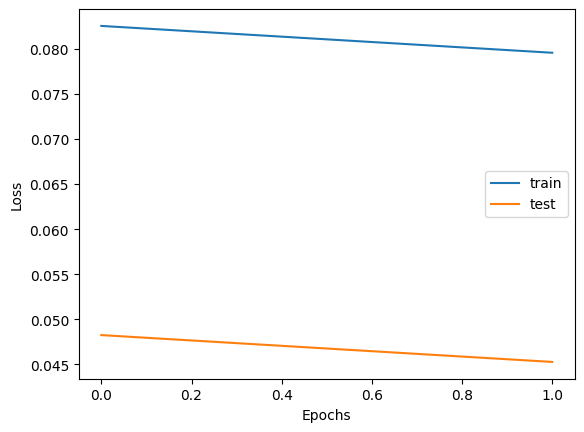

In [187]:
history = model.fit(X_train, Y_train, epochs=2, batch_size=128, validation_split=0.1,  verbose=1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [199]:
from sklearn.metrics import mean_squared_error, r2_score


# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 19)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 19)).reshape(Y_test.shape)


# Calculate MSE for each location and step
mse_values = np.zeros((steps_ahead, 19))
for step in range(steps_ahead):
    for location in range(19):
        mse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location])

# Calculate the average MSE across all locations and steps
average_mse = np.mean(mse_values)
print("Average Squared Mean Error:", average_mse, ", not squared:", np.sqrt(average_mse))

r2 = r2_score(Y_test.reshape(-1, 19), Y_pred.reshape(-1, 19))
print("R2 Score:", r2)

1/1 [==============================] - 3s 3s/step - loss: 0.0626
Test Loss: 0.06256982684135437
1/1 [==============================] - 3s 3s/step
Average Squared Mean Error: 36644465.87293225 , not squared: 6053.467260416319
R2 Score: -3.1009468242201956


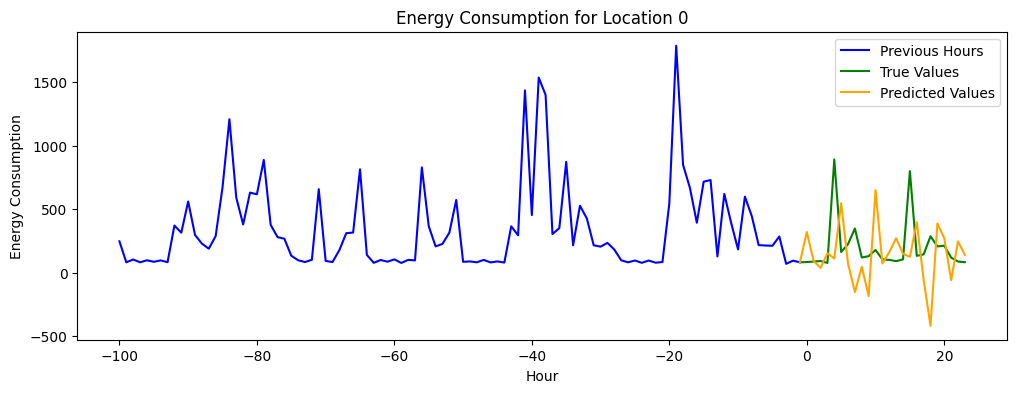

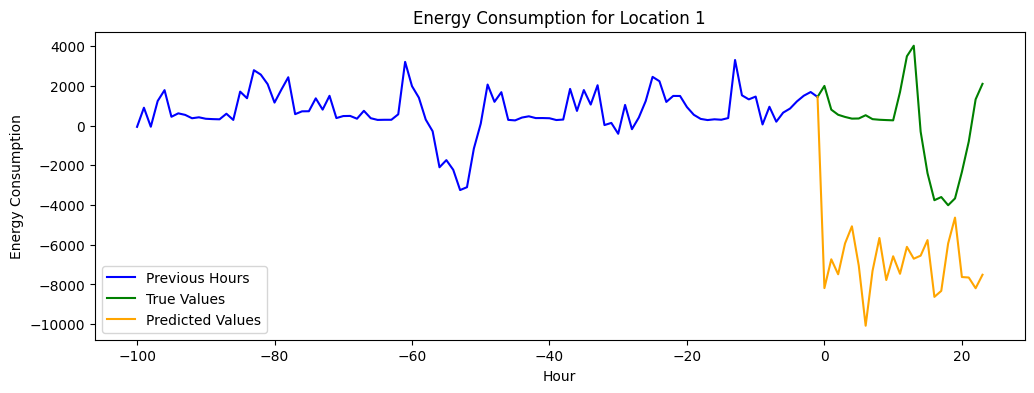

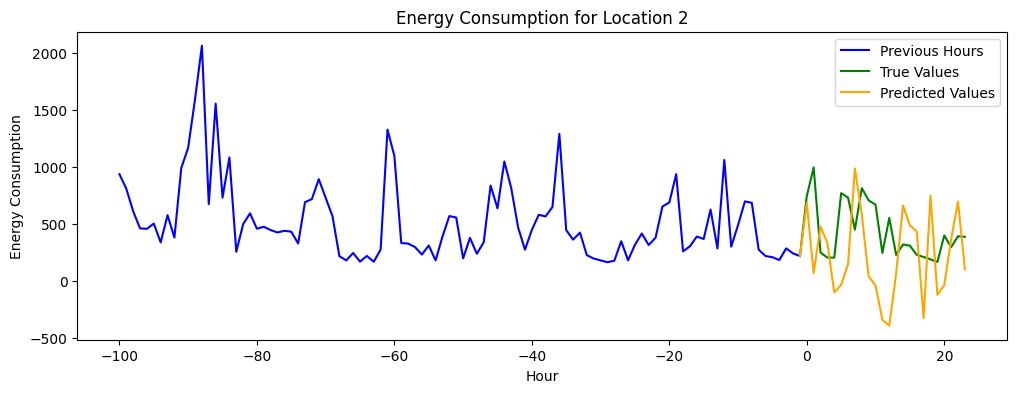

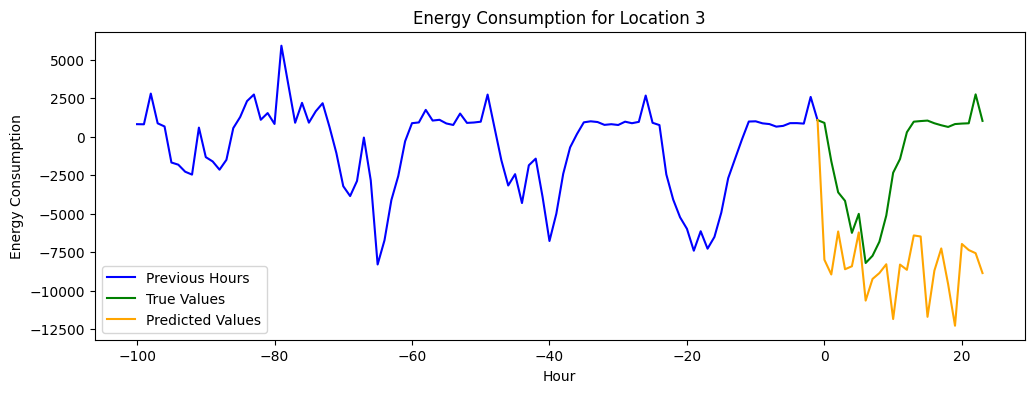

In [206]:
locations_to_plot = [0, 1, 2, 3]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead)


In [211]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape



steps_ahead = 24

# Your create_two_thirds_overlapping_sequences function and data splitting code remain the same

seq_length = 300
X, Y = create_overlapping_sequences(scaled_data, seq_length)

# Split the data into train and test sets
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Create the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=12, activation='relu', input_shape=(seq_length, X.shape[2])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(19 * steps_ahead),
    Reshape((steps_ahead, 19))
])

model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Your evaluation and plotting code remains the same


Epoch 1/10
3/3 [==============================] - 1s 183ms/step - loss: 0.1887 - val_loss: 0.1239
Epoch 2/10
3/3 [==============================] - 0s 143ms/step - loss: 0.0782 - val_loss: 0.1374
Epoch 3/10
3/3 [==============================] - 0s 142ms/step - loss: 0.0554 - val_loss: 0.0645
Epoch 4/10
3/3 [==============================] - 0s 139ms/step - loss: 0.0357 - val_loss: 0.0401
Epoch 5/10
3/3 [==============================] - 0s 144ms/step - loss: 0.0240 - val_loss: 0.0363
Epoch 6/10
3/3 [==============================] - 0s 141ms/step - loss: 0.0238 - val_loss: 0.0366
Epoch 7/10
3/3 [==============================] - 0s 138ms/step - loss: 0.0205 - val_loss: 0.0343
Epoch 8/10
3/3 [==============================] - 0s 144ms/step - loss: 0.0178 - val_loss: 0.0309
Epoch 9/10
3/3 [==============================] - 0s 141ms/step - loss: 0.0160 - val_loss: 0.0303
Epoch 10/10
3/3 [==============================] - 0s 141ms/step - loss: 0.0143 - val_loss: 0.0272


In [212]:
from sklearn.metrics import mean_squared_error, r2_score


# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 19)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 19)).reshape(Y_test.shape)


# Calculate MSE for each location and step
mse_values = np.zeros((steps_ahead, 19))
for step in range(steps_ahead):
    for location in range(19):
        mse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location])

# Calculate the average MSE across all locations and steps
average_mse = np.mean(mse_values)
print("Average Squared Mean Error:", average_mse, ", not squared:", np.sqrt(average_mse))

r2 = r2_score(Y_test.reshape(-1, 19), Y_pred.reshape(-1, 19))
print("R2 Score:", r2)

1/1 [==============================] - 0s 68ms/step - loss: 0.0175
Test Loss: 0.017526883631944656
1/1 [==============================] - 0s 103ms/step
Average Squared Mean Error: 11384.965342421172 , not squared: 106.70035305668473
R2 Score: 0.07521794150099724


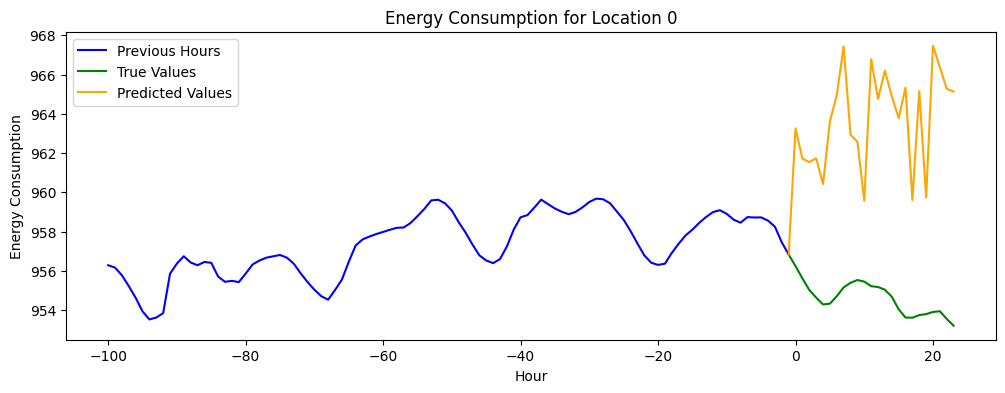

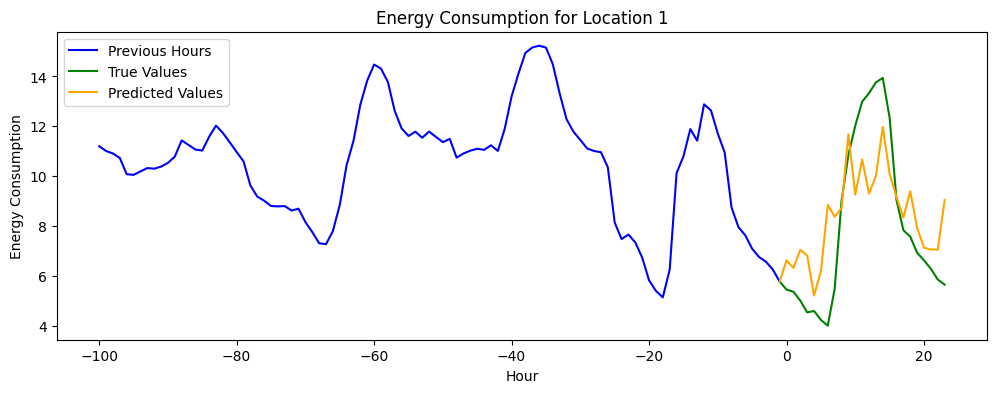

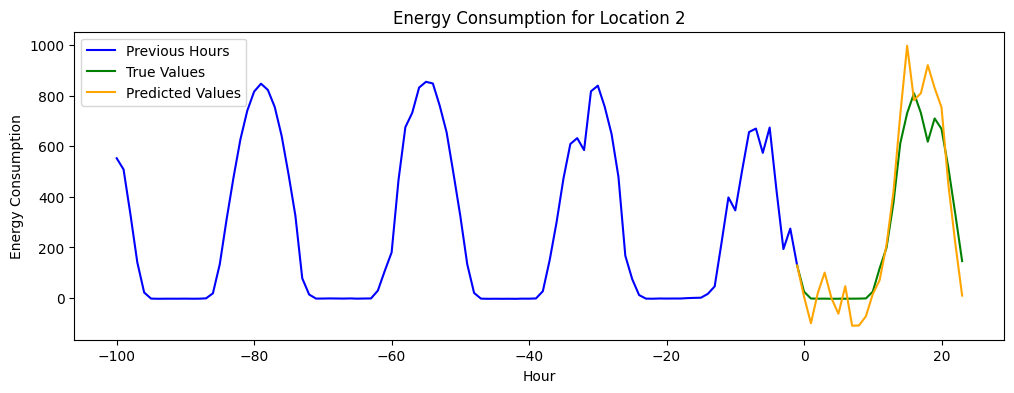

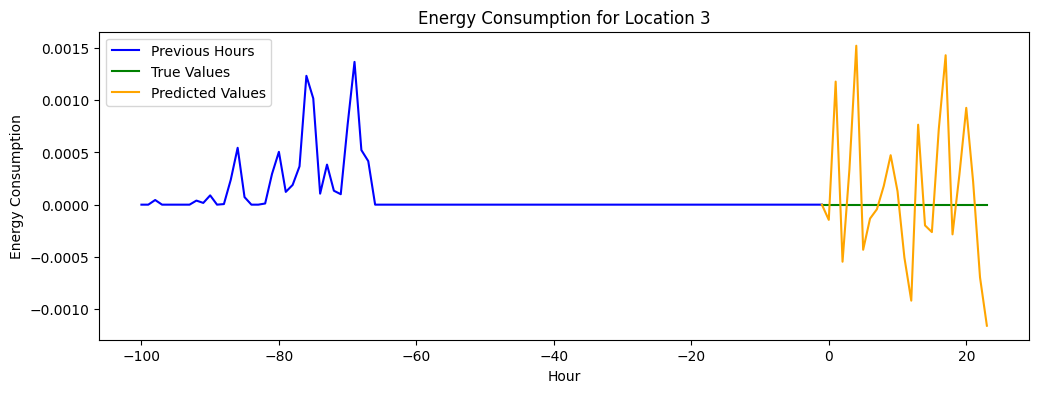

In [213]:
locations_to_plot = [0, 1, 2, 3]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead)


In [214]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, Input, Concatenate

# Your data preprocessing and sequence creation code remains the same

seq_length = 300


# First level of the hierarchical model
input_layer = Input(shape=(seq_length, X.shape[2]))
shared_conv = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
shared_flatten = Flatten()(shared_conv)

# Second level of the hierarchical model
location_models = []
for i in range(19):
    loc_conv = Conv1D(filters=32, kernel_size=3, activation='relu')(shared_conv)
    loc_flatten = Flatten()(loc_conv)
    loc_dense = Dense(steps_ahead)(loc_flatten)
    location_models.append(loc_dense)

# Combine the location-specific predictions
combined = Concatenate(axis=-1)(location_models)
output_layer = Reshape((steps_ahead, 19))(combined)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)



Epoch 1/10
18/18 [==============================] - 12s 451ms/step - loss: 0.1646 - val_loss: 0.0541
Epoch 2/10
18/18 [==============================] - 8s 438ms/step - loss: 0.0212 - val_loss: 0.0269
Epoch 3/10
18/18 [==============================] - 8s 427ms/step - loss: 0.0146 - val_loss: 0.0213
Epoch 4/10
18/18 [==============================] - 8s 437ms/step - loss: 0.0125 - val_loss: 0.0225
Epoch 5/10
18/18 [==============================] - 8s 440ms/step - loss: 0.0118 - val_loss: 0.0200
Epoch 6/10
18/18 [==============================] - 8s 440ms/step - loss: 0.0104 - val_loss: 0.0197
Epoch 7/10
18/18 [==============================] - 8s 438ms/step - loss: 0.0097 - val_loss: 0.0193
Epoch 8/10
18/18 [==============================] - 8s 444ms/step - loss: 0.0090 - val_loss: 0.0178
Epoch 9/10
18/18 [==============================] - 8s 464ms/step - loss: 0.0083 - val_loss: 0.0182
Epoch 10/10
18/18 [==============================] - 9s 482ms/step - loss: 0.0077 - val_loss: 0.018

In [221]:
from sklearn.metrics import mean_squared_error, r2_score


# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 19)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 19)).reshape(Y_test.shape)


# Calculate MSE for each location and step
mse_values = np.zeros((steps_ahead, 19))
for step in range(steps_ahead):
    for location in range(19):
        mse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location])

# Calculate the average MSE across all locations and steps
average_mse = np.mean(mse_values)
print("Average Squared Mean Error:", average_mse, ", not squared:", np.sqrt(average_mse))

r2 = r2_score(Y_test.reshape(-1, 19), Y_pred.reshape(-1, 19))
print("R2 Score:", r2)

5/5 [==============================] - 1s 125ms/step - loss: 0.0108
Test Loss: 0.010810413397848606
5/5 [==============================] - 1s 129ms/step
Average Squared Mean Error: 6636.067200621343 , not squared: 81.46205988447225
R2 Score: 0.6510786793894796


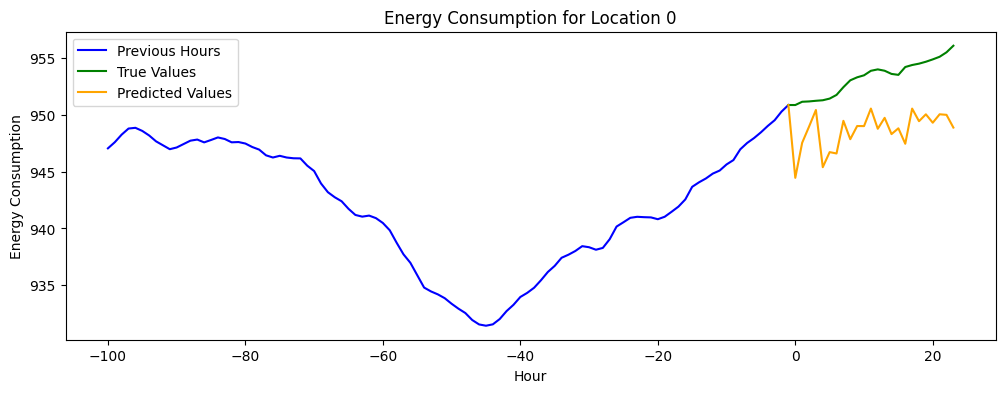

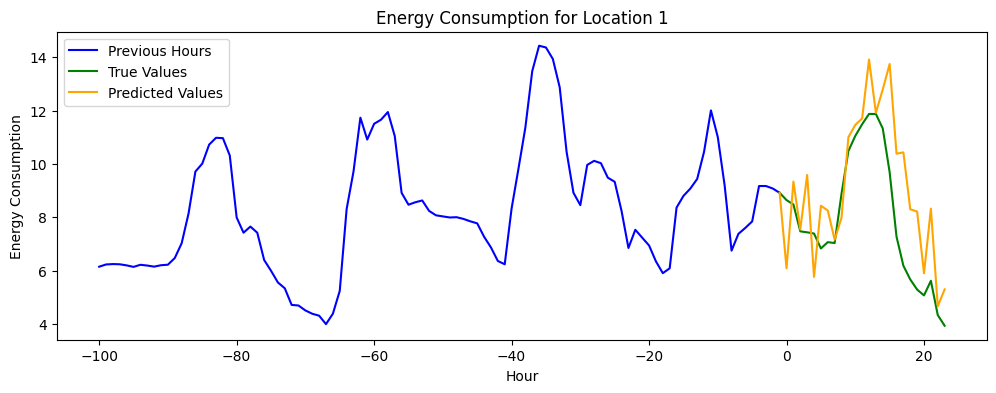

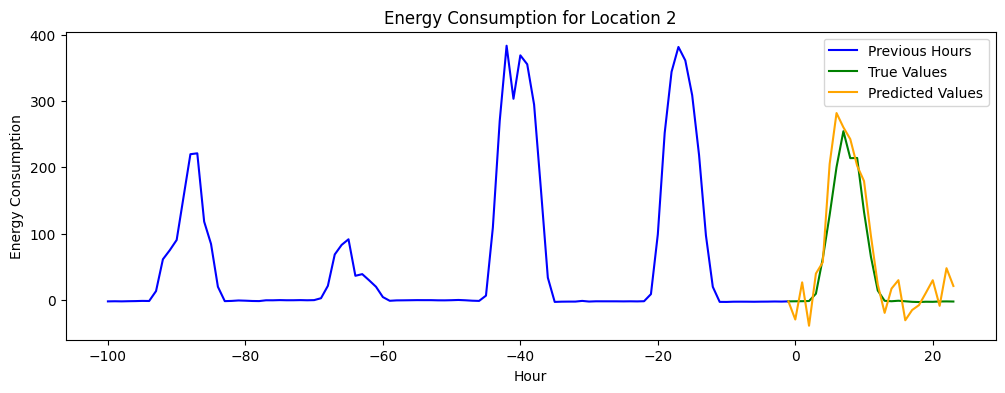

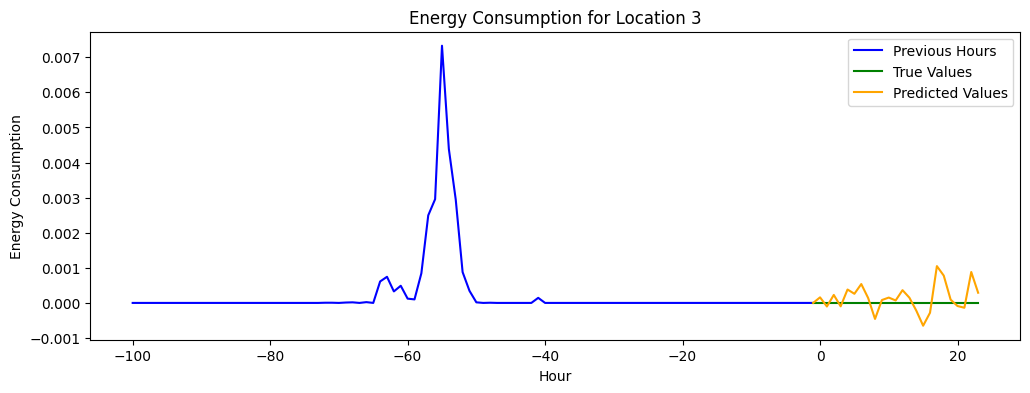

In [217]:
locations_to_plot = [0, 1, 2, 3]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead)


c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


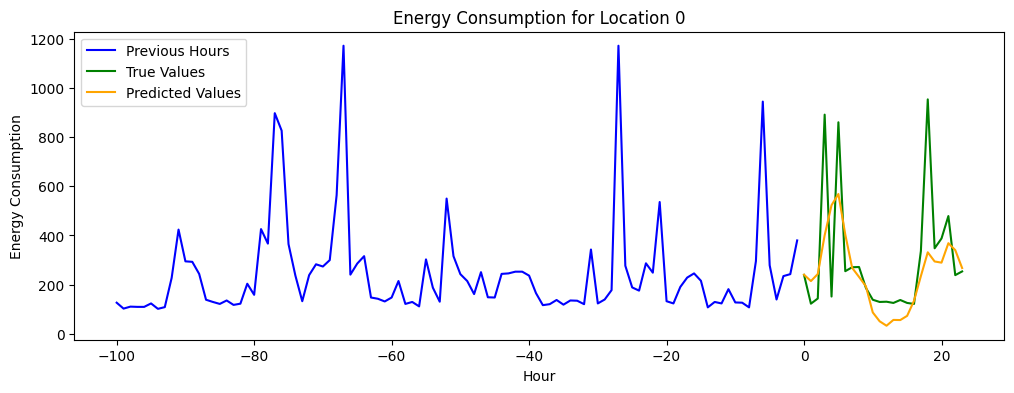

In [232]:
def plot_sarima_prediction_for_locations(locations, data, n_previous=100, steps_ahead=24):
    train_size = int(0.8 * len(data))

    for location in locations:
        location_data = data.iloc[:, location]
        train, test = location_data[:train_size], location_data[train_size:]

        # fit the SARIMA model and make predictions
        sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
        predictions = sarima_model.forecast(steps=24)

        # plot the predictions and true values
        
        previous_hours = train[-n_previous:]
        previous_hours_x = np.arange(-n_previous, 0)
        prediction_x = np.arange(0, steps_ahead)

        plt.figure(figsize=(12, 4))
        plt.plot(previous_hours_x, previous_hours, label='Previous Hours', color='blue')
        plt.plot(prediction_x, test[:steps_ahead], label='True Values', color='green')
        plt.plot(prediction_x, predictions[:steps_ahead], label='Predicted Values', color='orange')

        plt.xlabel('Hour')
        plt.ylabel('Energy Consumption')
        plt.title(f'Energy Consumption for Location {location}')
        plt.legend()
        plt.show()

locations = [0, 1, 2, 3, 4, 5, 6, 7]
plot_sarima_prediction_for_locations(locations, data)

In [228]:
data

,e_pos_neg_sum_0,e_pos_neg_sum_1,e_pos_neg_sum_2,e_pos_neg_sum_3,e_pos_neg_sum_4,e_pos_neg_sum_5,e_pos_neg_sum_6,e_pos_neg_sum_7,e_pos_neg_sum_8,e_pos_neg_sum_9,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour
0,485.0,810.0,1862.0,2469.0,1445.581219,1457.0,3311.0,794.0,559.0,847.0,...,0,0,0,0,0,0,0,0,0,0
1,218.0,1433.0,1679.0,2330.0,1317.436378,3292.0,3039.0,659.0,634.0,1574.0,...,0,0,0,0,0,0,0,0,0,1
2,224.0,2046.0,1749.0,2457.0,1185.000000,1029.0,1919.0,477.0,685.0,828.0,...,0,0,0,0,0,0,0,0,0,2
3,287.0,1688.0,1879.0,2123.0,558.000000,425.0,2592.0,410.0,288.0,341.0,...,0,0,0,0,0,0,0,0,0,3
4,227.0,1762.0,1998.0,4850.0,522.000000,2439.0,3351.0,402.0,317.0,307.0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,262.0,2515.0,2251.0,2948.0,1903.000000,3052.0,1570.0,1019.0,1324.0,549.0,...,0,0,0,0,0,0,0,1,0,18
16723,1037.0,2458.0,1263.0,3406.0,1518.000000,4415.0,1618.0,1057.0,536.0,434.0,...,0,0,0,0,0,0,0,1,0,19
16724,948.0,637.0,1235.0,2146.0,1800.000000,2901.0,1812.0,1043.0,499.0,371.0,...,0,0,0,0,0,0,0,1,0,20
16725,215.0,464.0,1191.0,1159.0,1059.000000,3217.0,1350.0,809.0,357.0,369.0,...,0,0,0,0,0,0,0,1,0,21


In [106]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Load your dataset
data = df_nc_t.drop(columns=['Date', "e_pos_battery", "e_neg_battery", "e_pos_PCC", "e_neg_PCC", "e_pos_PCC_batt", "e_neg_PCC_batt"])

steps_ahead = 24
num_locations = 19
mse_scores = []
r2_scores = []
num_features = data.shape[1] - num_locations

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

label_scaler = MinMaxScaler(feature_range=(0, 1))
label_scaler.fit(data.iloc[:, -num_locations:])

# Create sequences and split into train and test sets
seq_length = 500
X, Y = create_overlapping_sequences(scaled_data, seq_length, steps_ahead=24)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

for location in range(num_locations):
    print(f"Training model for location {location}")

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(128*2, input_shape=(seq_length, data.shape[1]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(steps_ahead))
    model.compile(loss='mse', optimizer='adam')

    # Train the model
    history = model.fit(X_train, Y_train[:, :, location], epochs=8, batch_size=32, validation_split=0.1, verbose=1)

    # Evaluate the model
    test_loss = model.evaluate(X_test, Y_test[:, :, location], verbose=1)
    print(f"Test Loss for location {location}:", test_loss)

    # Predict the test data
    Y_pred = model.predict(X_test)

    # Inverse scale the predictions and true values
    column_scale = label_scaler.scale_[location]
    column_min = label_scaler.min_[location]
    Y_pred_not_scaled = (Y_pred - column_min) / column_scale
    Y_test_not_scaled = (Y_test[:, :, location] - column_min) / column_scale


    # Calculate the MSE and R2 score
    me = mean_squared_error(Y_test_not_scaled, Y_pred_not_scaled)**0.5
    r2 = r2_score(Y_test_not_scaled, Y_pred_not_scaled)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"MSE for location {location}:", mse)
    print(f"R2 Score for location {location}:", r2)
    print("\n")

# Calculate mean scores
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print("Mean MSE:", mean_mse)
print("Mean R2 Score:", mean_r2)



Training model for location 0
Epoch 1/8
11/11 [==============================] - 101s 9s/step - loss: 0.0216 - val_loss: 0.0069
Epoch 2/8
11/11 [==============================] - 86s 8s/step - loss: 0.0089 - val_loss: 0.0045
Epoch 3/8
11/11 [==============================] - 78s 7s/step - loss: 0.0079 - val_loss: 0.0046
Epoch 4/8
11/11 [==============================] - 78s 7s/step - loss: 0.0076 - val_loss: 0.0043
Epoch 5/8
11/11 [==============================] - 78s 7s/step - loss: 0.0074 - val_loss: 0.0038
Epoch 6/8
11/11 [==============================] - 78s 7s/step - loss: 0.0071 - val_loss: 0.0038
Epoch 7/8
11/11 [==============================] - 78s 7s/step - loss: 0.0071 - val_loss: 0.0038
Epoch 8/8
3/3 [==============================] - 4s 1s/step - loss: 0.0197
Test Loss for location 0: 0.01974681206047535
3/3 [==============================] - 5s 1s/step
MSE for location 0: 684.163083544857
R2 Score for location 0: 0.027134547759305943


Training model for location 1
Epoc

In [ ]:
256, 6681
128, 256, 6766
128, 64, 32, 7000
128*4, 1000 sequences, 5000

In [ ]:
# Reshape the input features for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(2))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=50, verbose=0)

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error: %.3f' % mse)


In [ ]:
# Define the LinearForecaster model
class LinearForecaster:
    def __init__(self):
        self.theta = None
        self.target_cols = None

    def fit(self, X, y):
        self.target_cols = y.columns
        self.theta = np.linalg.pinv(X.values.T@X.values)@(X.values.T@y.values)
        return self
    
    def predict(self, X):
        preds = X.values @ self.theta
        return pd.DataFrame(preds, index=X.index, columns=self.target_cols)       

In [ ]:
def get_hankel(df, embedding=3):
    dfs = {}
    for c in df.columns:
        df_i = pd.concat([df[[c]].shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]
        df_i.columns = [i for i in range(df_i.shape[1])]
        dfs[c] = df_i
    return pd.concat(dfs, axis=1)

In [ ]:
df_trial = pd.DataFrame()
df_trial['e_pos'] = df[(0, 'e_pos')]
# df_trial.index.names = ['datetime']
df_trial.head()

In [ ]:
# Compute training and testing sets

train_period = 24*5  # Train on 5 days
tr_ratio = 0.75

forecast_periods = [train_period-i for i in range(1, 25)]
period_name = ['1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h']

train_test_splits = {}

for f_period_name, forecast_period in zip(period_name, forecast_periods):
    # print(f'Forecast period: {f_period_name}')
    # print(f'Forecast period length: {forecast_period} hours')
    df_emb = get_hankel(df_trial, embedding = train_period)
    x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
    y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]

    n_tr = int(len(x) * tr_ratio)
    X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
    y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

    train_test_splits[f'{f_period_name}'] = [X_train, y_train, X_test, y_test]

In [ ]:
# Train multiple Linear regresssion models on the different datasets, and save results
scores = {}
for split_name, train_test in train_test_splits.items():
    # Train a linear regression model
    lr = LinearForecaster()
    lr.fit(train_test[0], train_test[1])
    y_train_pred_lr = lr.predict(train_test[0])
    y_test_pred_lr = lr.predict(train_test[2])

    # List of scores, in order: [RMSE, R2]
    score_string = f'Linear {split_name}'

    scores[score_string] = [mean_squared_error(train_test[3], y_test_pred_lr, squared=False), 
                                        r2_score(train_test[3], y_test_pred_lr)]

    # Print results for the different models
    # print(f'Linear {split_name} scores:')
    # print(f'Training RMSE: {mean_squared_error(train_test[1], y_train_pred_lr, squared=False):.2f}')
    # print(f'Testing RMSE: {scores[f"{score_string}"][0]:.2f}')
    # print(f'Training R2: {r2_score(train_test[1], y_train_pred_lr):.2f}')
    # print(f'Testing R2: {scores[f"{score_string}"][1]:.2f}')
    # print('-'*50, '\n')

In [ ]:
# TODO - terminate the multivariate linear regression model

In [ ]:
df.head()

In [ ]:
# Define embeddings for the different datasets and forecast periods
for f_period_name, forecast_period in forecast_periods.items():
    # Compute training and testing sets
    df_emb = get_hankel(df, embedding = train_period)
    x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
    x["dayminute"] = np.sin((x.index.hour * 60 + x.index.minute) / (1410) * 2 * np.pi - np.pi)/2
    x["dayofyear"] = x.index.dayofyear / 365
    
    y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]['PM10']

    n_tr = int(len(x) * tr_ratio)
    X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
    y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

    train_test_splits[f'{df_name} {f_period_name}'] = [X_train, y_train, X_test, y_test]

# Model selection

In [ ]:
# Preprocess the data
# You can apply any additional preprocessing steps based on your dataset's requirements
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[df.columns.levels[0] == 'general'] = scaler.fit_transform(df[df.columns.levels[0] == 'general'])

# Split the data into training and validation sets
train_df, val_df = train_test_split(scaled_df, test_size=0.2, shuffle=False, random_state=42)

# Bottom-up hierarchical modeling
# Train individual models for each station's epos and eneg values
models = {}
for station in df.columns.levels[1]:
    for variable in ['epos', 'eneg']:
        X_train = train_df.loc[:, ('general', 'general')].values
        y_train = train_df.loc[:, (slice(None), station, variable)].values.ravel()

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        models[(station, variable)] = model

# Validate the models on the validation set
X_val = val_df.loc[:, ('general', 'general')].values
y_val_true = val_df.loc[:, (slice(None), slice(None), ['epos', 'eneg'])].values.reshape(-1)
y_val_pred = np.zeros_like(y_val_true)

for i, (station, variable) in enumerate(models.keys()):
    model = models[(station, variable)]
    y_val_pred[i::len(models)] = model.predict(X_val)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val_true, y_val_pred)
print(f'Mean Absolute Error: {mae:.2f}')
